# Rossmann Store Sales
<h3> Data fields </h3>

- Most of the fields are self-explanatory. The following are descriptions for those that aren't.
- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [212]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import math
from sklearn.feature_selection import chi2, mutual_info_regression, SelectKBest
from sklearn.preprocessing import power_transform, PowerTransformer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score, cross_validate, KFold, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import VotingRegressor,StackingClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

In [2]:
train= pd.read_csv('data/train.csv')
train.head(-20)

/var/folders/dy/djwbtyq128v9983t7_8yrpwh0000gn/T/ipykernel_36663/252456558.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train= pd.read_csv('data/train.csv')


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017184,1091,2,2013-01-01,0,0,0,0,a,1
1017185,1092,2,2013-01-01,0,0,0,0,a,1
1017186,1093,2,2013-01-01,0,0,0,0,a,1
1017187,1094,2,2013-01-01,0,0,0,0,a,1


In [3]:
train['Store'].nunique()

1115

In [4]:
train['Date']=pd.to_datetime(train['Date'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [5]:
(train[train['Open'] == 0][['Open', 'Sales']])

,Open,Sales
291,0,0
875,0,0
1406,0,0
1990,0,0
2521,0,0
...,...,...
1017204,0,0
1017205,0,0
1017206,0,0
1017207,0,0


In [6]:
(train[train['Sales'] == 0][['Open', 'Sales']])

,Open,Sales
291,0,0
875,0,0
1406,0,0
1990,0,0
2521,0,0
...,...,...
1017204,0,0
1017205,0,0
1017206,0,0
1017207,0,0


In [7]:
train.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [8]:
train['StateHoliday'].value_counts()
train['IsHoliday']=train['StateHoliday']
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,IsHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1,0
1,2,5,2015-07-31,6064,625,1,1,0,1,0
2,3,5,2015-07-31,8314,821,1,1,0,1,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,0
4,5,5,2015-07-31,4822,559,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a
1017205,1112,2,2013-01-01,0,0,0,0,a,1,a
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a


In [9]:
train['IsHoliday']= train['IsHoliday'].replace({'a': 1, 'b':1, 'c':1, '0':0, 0:0})
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,IsHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1,0
1,2,5,2015-07-31,6064,625,1,1,0,1,0
2,3,5,2015-07-31,8314,821,1,1,0,1,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,0
4,5,5,2015-07-31,4822,559,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,1


In [10]:
train['StateHoliday'].value_counts()

StateHoliday
0    855087
0    131072
a     20260
b      6690
c      4100
Name: count, dtype: int64

In [11]:
train['IsHoliday'].value_counts()

IsHoliday
0    986159
1     31050
Name: count, dtype: int64

In [12]:
train['StateHoliday'] = train['StateHoliday'].replace('a', 'Public Holiday')
train['StateHoliday'] = train['StateHoliday'].replace('b', 'Easter Holiday')
train['StateHoliday'] = train['StateHoliday'].replace('c', 'Christmas Holiday')
train['StateHoliday'] = train['StateHoliday'].replace('0', 'Not Holiday')
train['StateHoliday'] = train['StateHoliday'].replace(0, 'Not Holiday')
train['StateHoliday'].value_counts()

StateHoliday
Not Holiday          986159
Public Holiday        20260
Easter Holiday         6690
Christmas Holiday      4100
Name: count, dtype: int64

<Axes: >

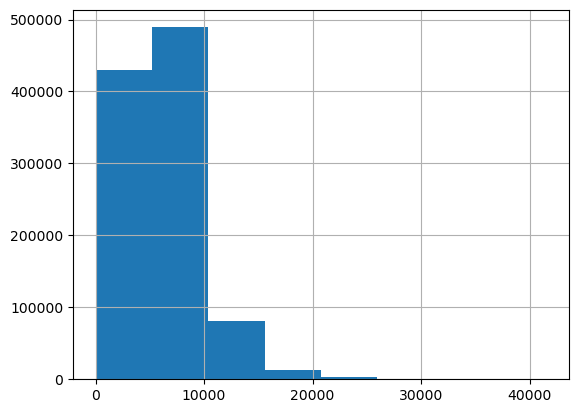

In [13]:
train['Sales'].hist(bins=8)

In [14]:
train['Sales'].value_counts()

Sales
0        172871
5674        215
5558        197
5483        196
6214        195
          ...  
23806         1
24183         1
20651         1
25083         1
23303         1
Name: count, Length: 21734, dtype: int64

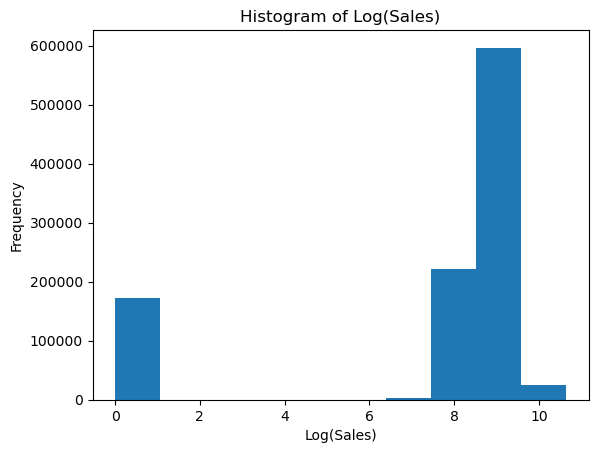

In [15]:
plt.hist(train['Sales'].apply(math.log1p), bins=10)
plt.xlabel('Log(Sales)')
plt.ylabel('Frequency')
plt.title('Histogram of Log(Sales)')
plt.show()

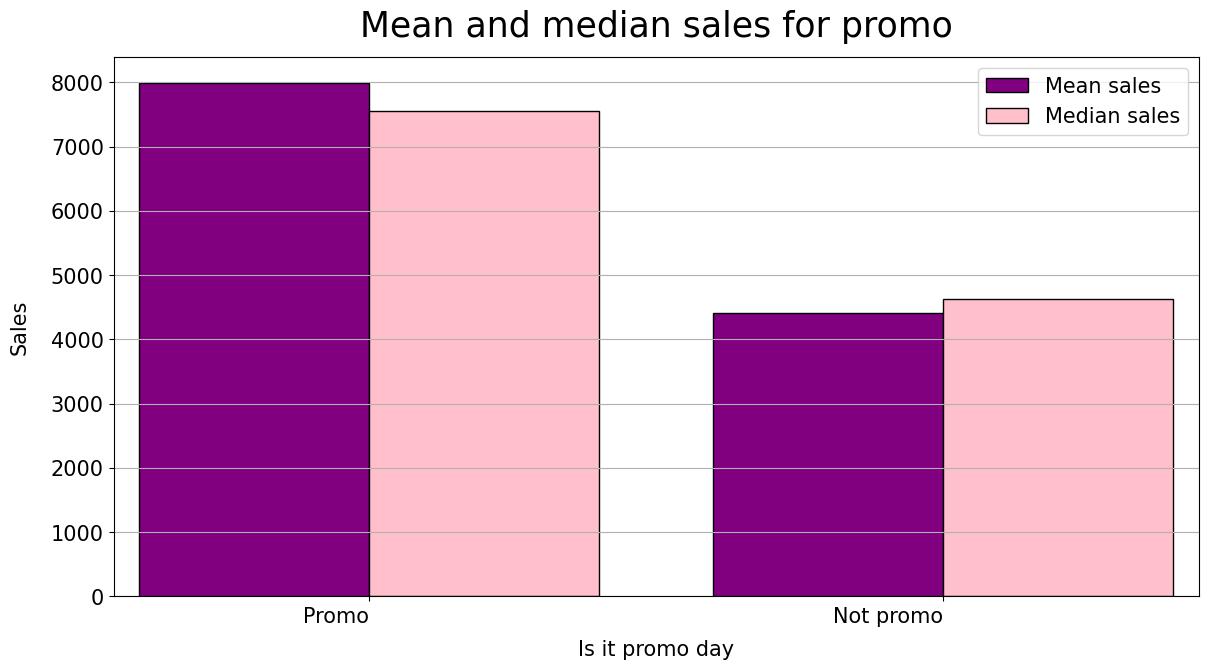

In [19]:
fig, ax = plt.subplots(figsize=(14, 7))

promo = train["Promo"].unique()
mean_sales = train.groupby("Promo")["Sales"].mean()
median_sales = train.groupby("Promo")["Sales"].median()
x = np.arange(0, len(promo), 1)
bars1 = ax.bar(x-0.2, mean_sales.loc[promo].values,width=0.4, color="purple", label="Mean sales", edgecolor="black")
bars2 = ax.bar(x+0.2,median_sales.loc[promo].values, width=0.4, color="pink", label="Median sales", edgecolor="black")
ax.set_title("Mean and median sales for promo", fontsize=25, pad=15)
ax.set_ylabel("Sales", fontsize=15, labelpad=15)
ax.set_xlabel("Is it promo day", fontsize=15, labelpad=10)
ax.set_xticks(x)
ax.set_xticklabels(['Promo', 'Not promo'], ha="right", rotation_mode='anchor')
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.grid(axis="y")
ax.margins(0.025, 0.05)
ax.legend(fontsize=15)
plt.show();

In [20]:
train.head(-20)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,IsHoliday
0,1,5,2015-07-31,5263,555,1,1,Not Holiday,1,0
1,2,5,2015-07-31,6064,625,1,1,Not Holiday,1,0
2,3,5,2015-07-31,8314,821,1,1,Not Holiday,1,0
3,4,5,2015-07-31,13995,1498,1,1,Not Holiday,1,0
4,5,5,2015-07-31,4822,559,1,1,Not Holiday,1,0
...,...,...,...,...,...,...,...,...,...,...
1017184,1091,2,2013-01-01,0,0,0,0,Public Holiday,1,1
1017185,1092,2,2013-01-01,0,0,0,0,Public Holiday,1,1
1017186,1093,2,2013-01-01,0,0,0,0,Public Holiday,1,1
1017187,1094,2,2013-01-01,0,0,0,0,Public Holiday,1,1


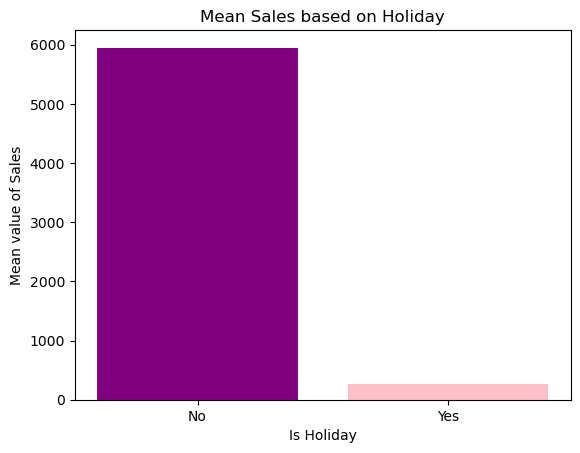

IsHoliday
0    5947.483893
1     258.159581
Name: Sales, dtype: float64

In [21]:
mean_by_hol = train.groupby('IsHoliday')['Sales'].mean()
mean_by_hol
plt.bar(['No','Yes'], mean_by_hol , color=['purple','pink'])
plt.xlabel('Is Holiday')
plt.ylabel('Mean value of Sales')
plt.title('Mean Sales based on Holiday')
plt.show()
mean_by_hol

In [22]:
train['Day'] = train['Date'].dt.day
train['Month'] = train['Date'].dt.month
train['Year'] = train['Date'].dt.year
train['WeekOfYear'] = train['Date'].dt.isocalendar().week

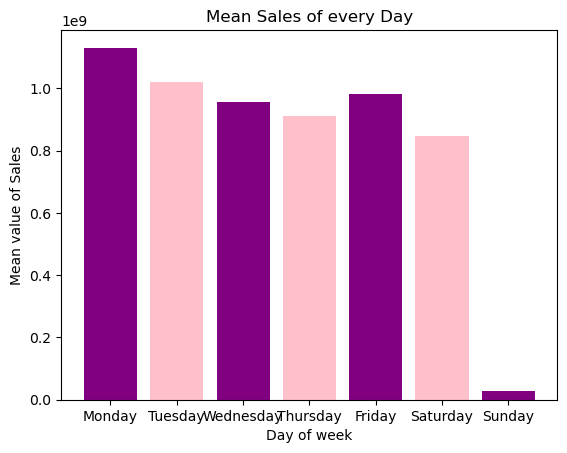

DayOfWeek
1    1130203012
2    1020411930
3     954962863
4     911177709
5     980555941
6     846317735
7      29551433
Name: Sales, dtype: int64

In [23]:
mean_sales_by_day = train.groupby('DayOfWeek')['Sales'].sum()
plt.bar(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], mean_sales_by_day , color=['purple','pink'])
plt.xlabel('Day of week')
plt.ylabel('Mean value of Sales')
plt.title('Mean Sales of every Day')
plt.show()
mean_sales_by_day

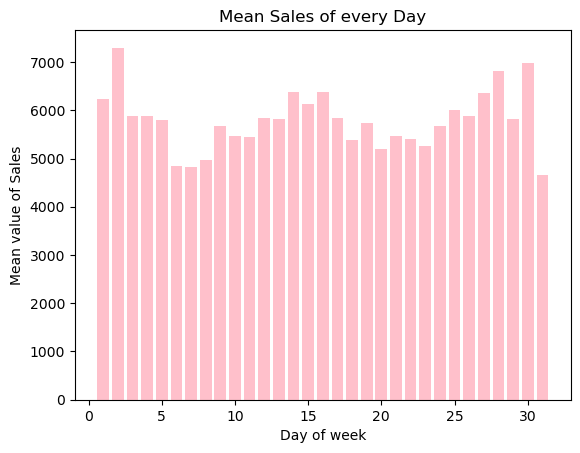

In [24]:
mean_sales_by_day = train.groupby('Day')['Sales'].mean()
plt.bar(train['Day'].unique(), mean_sales_by_day , color=['pink'])
plt.xlabel('Day of week')
plt.ylabel('Mean value of Sales')
plt.title('Mean Sales of every Day')
plt.show()

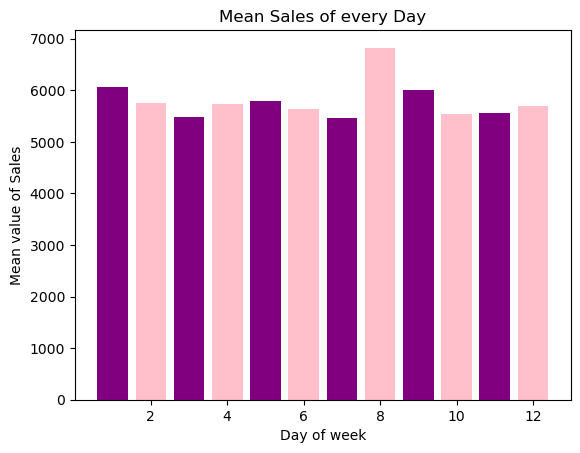

In [25]:
mean_sales_by_day = train.groupby('Month')['Sales'].mean()
plt.bar(train['Month'].unique(), mean_sales_by_day , color=['purple','pink'])
plt.xlabel('Month')
plt.ylabel('Mean value of Sales')
plt.title('Mean Sales of every Month')
plt.show()

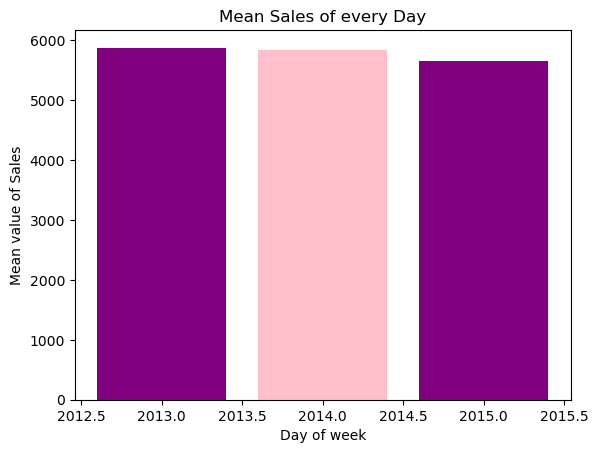

In [26]:
mean_sales_by_day = train.groupby('Year')['Sales'].mean()
plt.bar(train['Year'].unique(), mean_sales_by_day , color=['purple','pink'])
plt.xlabel('Year')
plt.ylabel('Mean value of Sales')
plt.title('Mean Sales for every Year')
plt.show()

In [27]:
ohe_holiday = pd.get_dummies(train, columns=['StateHoliday'], prefix=None)
ohe_holiday=ohe_holiday.iloc[:,-4:]
ohe_holiday=ohe_holiday.astype(int)
ohe_holiday.columns=['Christmas Holiday', 'Easter Holiday', 'Not Holiday', 'Public Holiday']
ohe_holiday

,Christmas Holiday,Easter Holiday,Not Holiday,Public Holiday
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
1017204,0,0,0,1
1017205,0,0,0,1
1017206,0,0,0,1
1017207,0,0,0,1


In [28]:
(ohe_holiday.sum(axis=1)).nunique()

1

In [29]:
train= pd.concat([train, ohe_holiday], axis=1)
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,IsHoliday,Day,Month,Year,WeekOfYear,Christmas Holiday,Easter Holiday,Not Holiday,Public Holiday
0,1,5,2015-07-31,5263,555,1,1,Not Holiday,1,0,31,7,2015,31,0,0,1,0
1,2,5,2015-07-31,6064,625,1,1,Not Holiday,1,0,31,7,2015,31,0,0,1,0
2,3,5,2015-07-31,8314,821,1,1,Not Holiday,1,0,31,7,2015,31,0,0,1,0
3,4,5,2015-07-31,13995,1498,1,1,Not Holiday,1,0,31,7,2015,31,0,0,1,0
4,5,5,2015-07-31,4822,559,1,1,Not Holiday,1,0,31,7,2015,31,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,Public Holiday,1,1,1,1,2013,1,0,0,0,1
1017205,1112,2,2013-01-01,0,0,0,0,Public Holiday,1,1,1,1,2013,1,0,0,0,1
1017206,1113,2,2013-01-01,0,0,0,0,Public Holiday,1,1,1,1,2013,1,0,0,0,1
1017207,1114,2,2013-01-01,0,0,0,0,Public Holiday,1,1,1,1,2013,1,0,0,0,1


In [30]:
train=train.drop('StateHoliday', axis=1)
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,IsHoliday,Day,Month,Year,WeekOfYear,Christmas Holiday,Easter Holiday,Not Holiday,Public Holiday
0,1,5,2015-07-31,5263,555,1,1,1,0,31,7,2015,31,0,0,1,0
1,2,5,2015-07-31,6064,625,1,1,1,0,31,7,2015,31,0,0,1,0
2,3,5,2015-07-31,8314,821,1,1,1,0,31,7,2015,31,0,0,1,0
3,4,5,2015-07-31,13995,1498,1,1,1,0,31,7,2015,31,0,0,1,0
4,5,5,2015-07-31,4822,559,1,1,1,0,31,7,2015,31,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,1,1,1,1,2013,1,0,0,0,1
1017205,1112,2,2013-01-01,0,0,0,0,1,1,1,1,2013,1,0,0,0,1
1017206,1113,2,2013-01-01,0,0,0,0,1,1,1,1,2013,1,0,0,0,1
1017207,1114,2,2013-01-01,0,0,0,0,1,1,1,1,2013,1,0,0,0,1


In [31]:
train['DayOfWeek'].value_counts()

DayOfWeek
5    145845
4    145845
3    145665
2    145664
1    144730
7    144730
6    144730
Name: count, dtype: int64

In [32]:
day_mapping = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
train['DayOfWeek']=train['DayOfWeek'].map(day_mapping)
train['DayOfWeek'].value_counts()

DayOfWeek
Friday       145845
Thursday     145845
Wednesday    145665
Tuesday      145664
Monday       144730
Sunday       144730
Saturday     144730
Name: count, dtype: int64

In [33]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,IsHoliday,Day,Month,Year,WeekOfYear,Christmas Holiday,Easter Holiday,Not Holiday,Public Holiday
0,1,Friday,2015-07-31,5263,555,1,1,1,0,31,7,2015,31,0,0,1,0
1,2,Friday,2015-07-31,6064,625,1,1,1,0,31,7,2015,31,0,0,1,0
2,3,Friday,2015-07-31,8314,821,1,1,1,0,31,7,2015,31,0,0,1,0
3,4,Friday,2015-07-31,13995,1498,1,1,1,0,31,7,2015,31,0,0,1,0
4,5,Friday,2015-07-31,4822,559,1,1,1,0,31,7,2015,31,0,0,1,0


In [34]:
ohe_day = pd.get_dummies(train, columns=['DayOfWeek'])
ohe_day=ohe_day.iloc[:,-7:]
ohe_day=ohe_day.astype(int)
ohe_day.columns=['Friday','Monday', 'Saturday', 'Sunday','Thursday','Tuesday','Wednesdayday']
ohe_day

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesdayday
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1017204,0,0,0,0,0,1,0
1017205,0,0,0,0,0,1,0
1017206,0,0,0,0,0,1,0
1017207,0,0,0,0,0,1,0


In [35]:
train= pd.concat([train, ohe_day],axis=1)
train=train.drop('DayOfWeek', axis=1)
train

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,IsHoliday,Day,Month,...,Easter Holiday,Not Holiday,Public Holiday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesdayday
0,1,2015-07-31,5263,555,1,1,1,0,31,7,...,0,1,0,1,0,0,0,0,0,0
1,2,2015-07-31,6064,625,1,1,1,0,31,7,...,0,1,0,1,0,0,0,0,0,0
2,3,2015-07-31,8314,821,1,1,1,0,31,7,...,0,1,0,1,0,0,0,0,0,0
3,4,2015-07-31,13995,1498,1,1,1,0,31,7,...,0,1,0,1,0,0,0,0,0,0
4,5,2015-07-31,4822,559,1,1,1,0,31,7,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2013-01-01,0,0,0,0,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
1017205,1112,2013-01-01,0,0,0,0,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
1017206,1113,2013-01-01,0,0,0,0,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
1017207,1114,2013-01-01,0,0,0,0,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0


In [36]:
train.isna().sum()

Store                0
Date                 0
Sales                0
Customers            0
Open                 0
Promo                0
SchoolHoliday        0
IsHoliday            0
Day                  0
Month                0
Year                 0
WeekOfYear           0
Christmas Holiday    0
Easter Holiday       0
Not Holiday          0
Public Holiday       0
Friday               0
Monday               0
Saturday             0
Sunday               0
Thursday             0
Tuesday              0
Wednesdayday         0
dtype: int64

In [37]:
month_mapping = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

train['MonthName'] = train['Month'].map(month_mapping)

In [38]:
train

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,IsHoliday,Day,Month,...,Not Holiday,Public Holiday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesdayday,MonthName
0,1,2015-07-31,5263,555,1,1,1,0,31,7,...,1,0,1,0,0,0,0,0,0,Jul
1,2,2015-07-31,6064,625,1,1,1,0,31,7,...,1,0,1,0,0,0,0,0,0,Jul
2,3,2015-07-31,8314,821,1,1,1,0,31,7,...,1,0,1,0,0,0,0,0,0,Jul
3,4,2015-07-31,13995,1498,1,1,1,0,31,7,...,1,0,1,0,0,0,0,0,0,Jul
4,5,2015-07-31,4822,559,1,1,1,0,31,7,...,1,0,1,0,0,0,0,0,0,Jul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2013-01-01,0,0,0,0,1,1,1,1,...,0,1,0,0,0,0,0,1,0,Jan
1017205,1112,2013-01-01,0,0,0,0,1,1,1,1,...,0,1,0,0,0,0,0,1,0,Jan
1017206,1113,2013-01-01,0,0,0,0,1,1,1,1,...,0,1,0,0,0,0,0,1,0,Jan
1017207,1114,2013-01-01,0,0,0,0,1,1,1,1,...,0,1,0,0,0,0,0,1,0,Jan


In [39]:
holidays= train[['Store','IsHoliday', 'WeekOfYear', 'Year']]#, 'Date']]
holidays

,Store,IsHoliday,WeekOfYear,Year
0,1,0,31,2015
1,2,0,31,2015
2,3,0,31,2015
3,4,0,31,2015
4,5,0,31,2015
...,...,...,...,...
1017204,1111,1,1,2013
1017205,1112,1,1,2013
1017206,1113,1,1,2013
1017207,1114,1,1,2013


In [40]:
holidays=pd.DataFrame(holidays.groupby(['Store', 'Year', 'WeekOfYear'])['IsHoliday'].sum())
holidays=holidays.reset_index(drop=False)
holidays = holidays.rename(columns={'IsHoliday': 'HolidayThisWeek'})
holidays['HolidayThisWeek']=holidays['HolidayThisWeek'].apply(lambda x: 1 if x>0 else 0)
holidays['HolidayThisWeek'].value_counts()
holidays['HolidayThisWeek'].sum()

28691

In [41]:
train = pd.merge(train, holidays, on=['Store', 'WeekOfYear', 'Year'], how='inner')
train=train.sort_values(['Store', 'Date'], ascending=[True, True])
train.head(40)

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,IsHoliday,Day,Month,...,Public Holiday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesdayday,MonthName,HolidayThisWeek
610242,1,2013-01-01,0,0,0,0,1,1,1,1,...,1,0,0,0,0,0,1,0,Jan,1
610241,1,2013-01-02,5530,668,1,0,1,0,2,1,...,0,0,0,0,0,0,0,1,Jan,1
610240,1,2013-01-03,4327,578,1,0,1,0,3,1,...,0,0,0,0,0,1,0,0,Jan,1
610239,1,2013-01-04,4486,619,1,0,1,0,4,1,...,0,1,0,0,0,0,0,0,Jan,1
610238,1,2013-01-05,4997,635,1,0,1,0,5,1,...,0,0,0,1,0,0,0,0,Jan,1
610237,1,2013-01-06,0,0,0,0,1,0,6,1,...,0,0,0,0,1,0,0,0,Jan,1
1009410,1,2013-01-07,7176,785,1,1,1,0,7,1,...,0,0,1,0,0,0,0,0,Jan,0
1009409,1,2013-01-08,5580,654,1,1,1,0,8,1,...,0,0,0,0,0,0,1,0,Jan,0
1009408,1,2013-01-09,5471,626,1,1,1,0,9,1,...,0,0,0,0,0,0,0,1,Jan,0
1009407,1,2013-01-10,4892,615,1,1,1,0,10,1,...,0,0,0,0,0,1,0,0,Jan,0


In [42]:
train['HolidayThisWeek'].sum()

199289

In [43]:
train

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,IsHoliday,Day,Month,...,Public Holiday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesdayday,MonthName,HolidayThisWeek
610242,1,2013-01-01,0,0,0,0,1,1,1,1,...,1,0,0,0,0,0,1,0,Jan,1
610241,1,2013-01-02,5530,668,1,0,1,0,2,1,...,0,0,0,0,0,0,0,1,Jan,1
610240,1,2013-01-03,4327,578,1,0,1,0,3,1,...,0,0,0,0,0,1,0,0,Jan,1
610239,1,2013-01-04,4486,619,1,0,1,0,4,1,...,0,1,0,0,0,0,0,0,Jan,1
610238,1,2013-01-05,4997,635,1,0,1,0,5,1,...,0,0,0,1,0,0,0,0,Jan,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5574,1115,2015-07-27,10712,608,1,1,1,0,27,7,...,0,0,1,0,0,0,0,0,Jul,0
5573,1115,2015-07-28,8093,500,1,1,1,0,28,7,...,0,0,0,0,0,0,1,0,Jul,0
5572,1115,2015-07-29,7661,473,1,1,1,0,29,7,...,0,0,0,0,0,0,0,1,Jul,0
5571,1115,2015-07-30,8405,502,1,1,1,0,30,7,...,0,0,0,0,0,1,0,0,Jul,0


In [44]:
holiday_prev_week= train[['Store','IsHoliday', 'WeekOfYear', 'Year']]#, 'Date']]
holiday_prev_week

,Store,IsHoliday,WeekOfYear,Year
610242,1,1,1,2013
610241,1,0,1,2013
610240,1,0,1,2013
610239,1,0,1,2013
610238,1,0,1,2013
...,...,...,...,...
5574,1115,0,31,2015
5573,1115,0,31,2015
5572,1115,0,31,2015
5571,1115,0,31,2015


In [45]:
holiday_prev_week=pd.DataFrame(holiday_prev_week.groupby(['Store', 'Year', 'WeekOfYear'])['IsHoliday'].sum()).shift(1)
holiday_prev_week=holiday_prev_week.reset_index(drop=False)
holiday_prev_week = holiday_prev_week.rename(columns={'IsHoliday': 'IsHolidayThePreviousWeek'})
holiday_prev_week['IsHolidayThePreviousWeek']=holiday_prev_week['IsHolidayThePreviousWeek'].fillna(0)
holiday_prev_week['IsHolidayThePreviousWeek']=holiday_prev_week['IsHolidayThePreviousWeek'].apply(lambda x: 1 if x>0 else 0)
holiday_prev_week['IsHolidayThePreviousWeek'] = np.where(holiday_prev_week['WeekOfYear'] == 1, 1, holiday_prev_week['IsHolidayThePreviousWeek'])

holiday_prev_week.head(139)

,Store,Year,WeekOfYear,IsHolidayThePreviousWeek
0,1,2013,1,1
1,1,2013,2,1
2,1,2013,3,0
3,1,2013,4,0
4,1,2013,5,0
...,...,...,...,...
134,1,2015,31,0
135,2,2013,1,1
136,2,2013,2,1
137,2,2013,3,0


In [46]:
holiday_prev_week['IsHolidayThePreviousWeek']=holiday_prev_week['IsHolidayThePreviousWeek'].astype(int)
holiday_prev_week['IsHolidayThePreviousWeek'].value_counts()

IsHolidayThePreviousWeek
0    116039
1     29986
Name: count, dtype: int64

In [47]:
train

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,IsHoliday,Day,Month,...,Public Holiday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesdayday,MonthName,HolidayThisWeek
610242,1,2013-01-01,0,0,0,0,1,1,1,1,...,1,0,0,0,0,0,1,0,Jan,1
610241,1,2013-01-02,5530,668,1,0,1,0,2,1,...,0,0,0,0,0,0,0,1,Jan,1
610240,1,2013-01-03,4327,578,1,0,1,0,3,1,...,0,0,0,0,0,1,0,0,Jan,1
610239,1,2013-01-04,4486,619,1,0,1,0,4,1,...,0,1,0,0,0,0,0,0,Jan,1
610238,1,2013-01-05,4997,635,1,0,1,0,5,1,...,0,0,0,1,0,0,0,0,Jan,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5574,1115,2015-07-27,10712,608,1,1,1,0,27,7,...,0,0,1,0,0,0,0,0,Jul,0
5573,1115,2015-07-28,8093,500,1,1,1,0,28,7,...,0,0,0,0,0,0,1,0,Jul,0
5572,1115,2015-07-29,7661,473,1,1,1,0,29,7,...,0,0,0,0,0,0,0,1,Jul,0
5571,1115,2015-07-30,8405,502,1,1,1,0,30,7,...,0,0,0,0,0,1,0,0,Jul,0


In [48]:
train = pd.merge(train, holiday_prev_week, on=['Store', 'WeekOfYear', 'Year'], how='inner')
train=train.sort_values(['Store', 'Date'], ascending=[True, True])
train.head()

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,IsHoliday,Day,Month,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesdayday,MonthName,HolidayThisWeek,IsHolidayThePreviousWeek
0,1,2013-01-01,0,0,0,0,1,1,1,1,...,0,0,0,0,0,1,0,Jan,1,1
1,1,2013-01-02,5530,668,1,0,1,0,2,1,...,0,0,0,0,0,0,1,Jan,1,1
2,1,2013-01-03,4327,578,1,0,1,0,3,1,...,0,0,0,0,1,0,0,Jan,1,1
3,1,2013-01-04,4486,619,1,0,1,0,4,1,...,1,0,0,0,0,0,0,Jan,1,1
4,1,2013-01-05,4997,635,1,0,1,0,5,1,...,0,0,1,0,0,0,0,Jan,1,1


In [49]:
train['IsHolidayThePreviousWeek'].sum()

208246

In [50]:
holiday_next_week= train[['Store','IsHoliday', 'WeekOfYear', 'Year']]#, 'Date']]
holiday_next_week

,Store,IsHoliday,WeekOfYear,Year
0,1,1,1,2013
1,1,0,1,2013
2,1,0,1,2013
3,1,0,1,2013
4,1,0,1,2013
...,...,...,...,...
1017204,1115,0,31,2015
1017205,1115,0,31,2015
1017206,1115,0,31,2015
1017207,1115,0,31,2015


In [51]:
holiday_next_week=pd.DataFrame(holiday_next_week.groupby(['Store', 'Year', 'WeekOfYear'])['IsHoliday'].sum()).shift(-1)
holiday_next_week.head(139)

IsHoliday
Store Year WeekOfYear           
1     2013 1                 0.0
           2                 0.0
           3                 0.0
           4                 0.0
           5                 0.0
...                          ...
      2015 31                1.0
2     2013 1                 0.0
           2                 0.0
           3                 0.0
           4                 0.0

[139 rows x 1 columns]

In [52]:
holiday_next_week=pd.DataFrame(holiday_next_week.groupby(['Store', 'Year', 'WeekOfYear'])['IsHoliday'].sum()).shift(-1)
holiday_next_week=holiday_next_week.reset_index(drop=False)
holiday_next_week['IsHoliday']=holiday_next_week['IsHoliday'].fillna(0)
holiday_next_week = holiday_next_week.rename(columns={'IsHoliday': 'IsHolidayNextWeek'})
holiday_next_week['IsHolidayNextWeek']=holiday_next_week['IsHolidayNextWeek'].apply(lambda x: 1 if x>0 else 0)
holiday_next_week['IsHolidayNextWeek'] = np.where(holiday_next_week['WeekOfYear'] == 31, 0, holiday_next_week['IsHolidayNextWeek'])

holiday_next_week['IsHolidayNextWeek']=holiday_next_week['IsHolidayNextWeek'].astype(int)
holiday_next_week.head(189)


,Store,Year,WeekOfYear,IsHolidayNextWeek
0,1,2013,1,0
1,1,2013,2,0
2,1,2013,3,0
3,1,2013,4,0
4,1,2013,5,0
...,...,...,...,...
184,2,2013,50,1
185,2,2013,51,1
186,2,2013,52,0
187,2,2014,1,0


In [53]:
train = pd.merge(train, holiday_next_week, on=['Store', 'WeekOfYear', 'Year'], how='inner')
train=train.sort_values(['Store', 'Date'], ascending=[True, True])
train.head()

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,IsHoliday,Day,Month,...,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesdayday,MonthName,HolidayThisWeek,IsHolidayThePreviousWeek,IsHolidayNextWeek
0,1,2013-01-01,0,0,0,0,1,1,1,1,...,0,0,0,0,1,0,Jan,1,1,0
1,1,2013-01-02,5530,668,1,0,1,0,2,1,...,0,0,0,0,0,1,Jan,1,1,0
2,1,2013-01-03,4327,578,1,0,1,0,3,1,...,0,0,0,1,0,0,Jan,1,1,0
3,1,2013-01-04,4486,619,1,0,1,0,4,1,...,0,0,0,0,0,0,Jan,1,1,0
4,1,2013-01-05,4997,635,1,0,1,0,5,1,...,0,1,0,0,0,0,Jan,1,1,0


In [54]:
holiday_prev_day= train[['Store','IsHoliday', 'Date', 'Year']]#, 'Date']]
holiday_prev_day

,Store,IsHoliday,Date,Year
0,1,1,2013-01-01,2013
1,1,0,2013-01-02,2013
2,1,0,2013-01-03,2013
3,1,0,2013-01-04,2013
4,1,0,2013-01-05,2013
...,...,...,...,...
1017204,1115,0,2015-07-27,2015
1017205,1115,0,2015-07-28,2015
1017206,1115,0,2015-07-29,2015
1017207,1115,0,2015-07-30,2015


In [55]:
holiday_prev_day=pd.DataFrame(holiday_prev_day.groupby(['Store', 'Year', 'Date'])['IsHoliday'].sum()).shift(1)
holiday_prev_day.head(733)

IsHoliday
Store Year Date                 
1     2013 2013-01-01        NaN
           2013-01-02        1.0
           2013-01-03        0.0
           2013-01-04        0.0
           2013-01-05        0.0
...                          ...
      2014 2014-12-30        0.0
           2014-12-31        0.0
      2015 2015-01-01        0.0
           2015-01-02        1.0
           2015-01-03        0.0

[733 rows x 1 columns]

In [56]:
holiday_prev_day=pd.DataFrame(holiday_prev_day.groupby(['Store', 'Year', 'Date'])['IsHoliday'].sum()).shift(1)
holiday_prev_day=holiday_prev_day.reset_index(drop=False)
holiday_prev_day['IsHoliday']=holiday_prev_day['IsHoliday'].fillna(0)
holiday_prev_day = holiday_prev_day.rename(columns={'IsHoliday': 'IsHolidayThePreviousDay'})
holiday_prev_day['IsHolidayThePreviousDay']=holiday_prev_day['IsHolidayThePreviousDay'].apply(lambda x: 1 if x>0 else 0)
holiday_prev_day['IsHolidayThePreviousDay']=holiday_prev_day['IsHolidayThePreviousDay'].astype(int)
holiday_prev_day.loc[holiday_prev_day['Date'].isin(['2013-01-01', '2014-01-01', '2015-01-01']), 'IsHolidayThePreviousDay'] = 0

holiday_prev_day.head(733)

,Store,Year,Date,IsHolidayThePreviousDay
0,1,2013,2013-01-01,0
1,1,2013,2013-01-02,0
2,1,2013,2013-01-03,1
3,1,2013,2013-01-04,0
4,1,2013,2013-01-05,0
...,...,...,...,...
728,1,2014,2014-12-30,0
729,1,2014,2014-12-31,0
730,1,2015,2015-01-01,0
731,1,2015,2015-01-02,0


In [57]:
train = pd.merge(train, holiday_prev_day, on=['Store', 'Date', 'Year'], how='inner')
train=train.sort_values(['Store', 'Date'], ascending=[True, True])
train.head()

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,IsHoliday,Day,Month,...,Saturday,Sunday,Thursday,Tuesday,Wednesdayday,MonthName,HolidayThisWeek,IsHolidayThePreviousWeek,IsHolidayNextWeek,IsHolidayThePreviousDay
0,1,2013-01-01,0,0,0,0,1,1,1,1,...,0,0,0,1,0,Jan,1,1,0,0
1,1,2013-01-02,5530,668,1,0,1,0,2,1,...,0,0,0,0,1,Jan,1,1,0,0
2,1,2013-01-03,4327,578,1,0,1,0,3,1,...,0,0,1,0,0,Jan,1,1,0,1
3,1,2013-01-04,4486,619,1,0,1,0,4,1,...,0,0,0,0,0,Jan,1,1,0,0
4,1,2013-01-05,4997,635,1,0,1,0,5,1,...,1,0,0,0,0,Jan,1,1,0,0


In [58]:
holiday_next_day= train[['Store','IsHoliday', 'Date', 'Year']]#, 'Date']]
holiday_next_day

,Store,IsHoliday,Date,Year
0,1,1,2013-01-01,2013
1,1,0,2013-01-02,2013
2,1,0,2013-01-03,2013
3,1,0,2013-01-04,2013
4,1,0,2013-01-05,2013
...,...,...,...,...
1017204,1115,0,2015-07-27,2015
1017205,1115,0,2015-07-28,2015
1017206,1115,0,2015-07-29,2015
1017207,1115,0,2015-07-30,2015


In [59]:
holiday_next_day=pd.DataFrame(holiday_next_day.groupby(['Store', 'Year', 'Date'])['IsHoliday'].sum()).shift(-1)
holiday_next_day=holiday_next_day.reset_index(drop=False)
holiday_next_day['IsHoliday']=holiday_next_day['IsHoliday'].fillna(0)
holiday_next_day = holiday_next_day.rename(columns={'IsHoliday': 'IsHolidayNextDay'})
holiday_next_day['IsHolidayNextDay']=holiday_next_day['IsHolidayNextDay'].apply(lambda x: 1 if x>0 else 0)
holiday_next_day['IsHolidayNextDay']=holiday_next_day['IsHolidayNextDay'].astype(int)
holiday_next_day.loc[holiday_next_day['Date'].isin(['2015-07-31']), 'IsHolidayNextDay'] = 0

holiday_next_day.head(945)

,Store,Year,Date,IsHolidayNextDay
0,1,2013,2013-01-01,0
1,1,2013,2013-01-02,0
2,1,2013,2013-01-03,0
3,1,2013,2013-01-04,0
4,1,2013,2013-01-05,0
...,...,...,...,...
940,1,2015,2015-07-30,0
941,1,2015,2015-07-31,0
942,2,2013,2013-01-01,0
943,2,2013,2013-01-02,0


In [60]:
train = pd.merge(train, holiday_next_day, on=['Store', 'Date', 'Year'], how='inner')
train=train.sort_values(['Store', 'Date'], ascending=[True, True])
train.head()

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,IsHoliday,Day,Month,...,Sunday,Thursday,Tuesday,Wednesdayday,MonthName,HolidayThisWeek,IsHolidayThePreviousWeek,IsHolidayNextWeek,IsHolidayThePreviousDay,IsHolidayNextDay
0,1,2013-01-01,0,0,0,0,1,1,1,1,...,0,0,1,0,Jan,1,1,0,0,0
1,1,2013-01-02,5530,668,1,0,1,0,2,1,...,0,0,0,1,Jan,1,1,0,0,0
2,1,2013-01-03,4327,578,1,0,1,0,3,1,...,0,1,0,0,Jan,1,1,0,1,0
3,1,2013-01-04,4486,619,1,0,1,0,4,1,...,0,0,0,0,Jan,1,1,0,0,0
4,1,2013-01-05,4997,635,1,0,1,0,5,1,...,0,0,0,0,Jan,1,1,0,0,0


In [61]:
#train=train.drop('Day', axis=1)
train = train[train['Sales'] != 0]
print(train['Open'].sum())
train=train.drop('Open', axis=1)
train.info()

844338
<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 1 to 1017208
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Store                     844338 non-null  int64         
 1   Date                      844338 non-null  datetime64[ns]
 2   Sales                     844338 non-null  int64         
 3   Customers                 844338 non-null  int64         
 4   Promo                     844338 non-null  int64         
 5   SchoolHoliday             844338 non-null  int64         
 6   IsHoliday                 844338 non-null  int64         
 7   Day                       844338 non-null  int32         
 8   Month                     844338 non-null  int32         
 9   Year                      844338 non-null  int32         
 10  WeekOfYear                844338 non-null  UInt32        
 11  Christmas Holiday         844338 non-null  int64         
 12 

In [62]:
store=pd.read_csv('data/store.csv')
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [63]:
store['Store'].nunique()

1115

In [64]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [65]:
ohe_store_type = pd.get_dummies(store, columns=['StoreType'], prefix='StoreType')
ohe_store_type=ohe_store_type.iloc[:,-4:]
ohe_store_type=ohe_store_type.astype(int)
ohe_store_type

,StoreType_a,StoreType_b,StoreType_c,StoreType_d
0,0,0,1,0
1,1,0,0,0
2,1,0,0,0
3,0,0,1,0
4,1,0,0,0
...,...,...,...,...
1110,1,0,0,0
1111,0,0,1,0
1112,1,0,0,0
1113,1,0,0,0


In [66]:
store= pd.concat([store, ohe_store_type], axis=1)
store=store.drop('StoreType', axis=1)
store

,Store,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d
0,1,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,0,0,1,0
1,2,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0
2,3,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0
3,4,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,0,0,1,0
4,5,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1,0,0,0
1111,1112,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,0,0,1,0
1112,1113,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,1,0,0,0
1113,1114,c,870.0,NaN,NaN,0,NaN,NaN,NaN,1,0,0,0


In [67]:
store['Assortment'].value_counts()

Assortment
a    593
c    513
b      9
Name: count, dtype: int64

In [68]:
store['Assortment']=store['Assortment'].apply(lambda x: "Basic" if x=='a' else("Extra" if x=='b' else "Extended" ))
store['Assortment'].value_counts()

Assortment
Basic       593
Extended    513
Extra         9
Name: count, dtype: int64

In [69]:
ohe_assortment_type = pd.get_dummies(store, columns=['Assortment'], prefix=None)
ohe_assortment_type=ohe_assortment_type.iloc[:,-3:]
ohe_assortment_type=ohe_assortment_type.astype(int)
ohe_assortment_type

,Assortment_Basic,Assortment_Extended,Assortment_Extra
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,1,0,0
...,...,...,...
1110,1,0,0
1111,0,1,0
1112,0,1,0
1113,0,1,0


In [70]:
ohe_assortment_type.sum()

Assortment_Basic       593
Assortment_Extended    513
Assortment_Extra         9
dtype: int64

In [71]:
store= pd.concat([store, ohe_assortment_type], axis=1)
store=store.drop('Assortment', axis=1)
store

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_Basic,Assortment_Extended,Assortment_Extra
0,1,1270.0,9.0,2008.0,0,NaN,NaN,NaN,0,0,1,0,1,0,0
1,2,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0
2,3,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0
3,4,620.0,9.0,2009.0,0,NaN,NaN,NaN,0,0,1,0,0,1,0
4,5,29910.0,4.0,2015.0,0,NaN,NaN,NaN,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0
1111,1112,1880.0,4.0,2006.0,0,NaN,NaN,NaN,0,0,1,0,0,1,0
1112,1113,9260.0,NaN,NaN,0,NaN,NaN,NaN,1,0,0,0,0,1,0
1113,1114,870.0,NaN,NaN,0,NaN,NaN,NaN,1,0,0,0,0,1,0


In [72]:
store.isna().sum()

Store                          0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
StoreType_a                    0
StoreType_b                    0
StoreType_c                    0
StoreType_d                    0
Assortment_Basic               0
Assortment_Extended            0
Assortment_Extra               0
dtype: int64

In [73]:
df_2015 = store[store['CompetitionOpenSinceYear'] == 2015]

max_month_2015 = df_2015['CompetitionOpenSinceMonth'].max()
max_month_2015

8.0

In [74]:
store['CompetitionOpenSinceYear'].max()

2015.0

In [75]:
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].apply(lambda x: 12 if pd.isna(x) else x)
store.isna().sum()

Store                          0
CompetitionDistance            3
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
StoreType_a                    0
StoreType_b                    0
StoreType_c                    0
StoreType_d                    0
Assortment_Basic               0
Assortment_Extended            0
Assortment_Extra               0
dtype: int64

In [76]:
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].apply(lambda x: 2020 if pd.isna(x) else x)
store.isna().sum()

Store                          0
CompetitionDistance            3
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
StoreType_a                    0
StoreType_b                    0
StoreType_c                    0
StoreType_d                    0
Assortment_Basic               0
Assortment_Extended            0
Assortment_Extra               0
dtype: int64

In [77]:
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].astype(int)
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpen']=pd.to_datetime(store['CompetitionOpenSinceYear'].astype(str) + '-'+ store['CompetitionOpenSinceMonth'].astype(str))
store

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_Basic,Assortment_Extended,Assortment_Extra,CompetitionOpen
0,1,1270.0,9,2008,0,NaN,NaN,NaN,0,0,1,0,1,0,0,2008-09-01
1,2,570.0,11,2007,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2007-11-01
2,3,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2006-12-01
3,4,620.0,9,2009,0,NaN,NaN,NaN,0,0,1,0,0,1,0,2009-09-01
4,5,29910.0,4,2015,0,NaN,NaN,NaN,1,0,0,0,1,0,0,2015-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,1900.0,6,2014,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2014-06-01
1111,1112,1880.0,4,2006,0,NaN,NaN,NaN,0,0,1,0,0,1,0,2006-04-01
1112,1113,9260.0,12,2020,0,NaN,NaN,NaN,1,0,0,0,0,1,0,2020-12-01
1113,1114,870.0,12,2020,0,NaN,NaN,NaN,1,0,0,0,0,1,0,2020-12-01


In [78]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      1115 non-null   int64         
 1   CompetitionDistance        1112 non-null   float64       
 2   CompetitionOpenSinceMonth  1115 non-null   int64         
 3   CompetitionOpenSinceYear   1115 non-null   int64         
 4   Promo2                     1115 non-null   int64         
 5   Promo2SinceWeek            571 non-null    float64       
 6   Promo2SinceYear            571 non-null    float64       
 7   PromoInterval              571 non-null    object        
 8   StoreType_a                1115 non-null   int64         
 9   StoreType_b                1115 non-null   int64         
 10  StoreType_c                1115 non-null   int64         
 11  StoreType_d                1115 non-null   int64         
 12  Assort

In [79]:
store.isna().sum()

Store                          0
CompetitionDistance            3
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
StoreType_a                    0
StoreType_b                    0
StoreType_c                    0
StoreType_d                    0
Assortment_Basic               0
Assortment_Extended            0
Assortment_Extra               0
CompetitionOpen                0
dtype: int64

In [80]:
store['Promo2SinceWeek']=store['Promo2SinceWeek'].apply(lambda x: 1 if pd.isna(x) else x)
store['Promo2SinceYear']=store['Promo2SinceYear'].apply(lambda x: 2023 if pd.isna(x) else x)
store['PromoInterval']=store['PromoInterval'].apply(lambda x: 'Missing' if pd.isna(x) else x)
store.isna().sum()

Store                        0
CompetitionDistance          3
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
StoreType_a                  0
StoreType_b                  0
StoreType_c                  0
StoreType_d                  0
Assortment_Basic             0
Assortment_Extended          0
Assortment_Extra             0
CompetitionOpen              0
dtype: int64

In [81]:
store

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_Basic,Assortment_Extended,Assortment_Extra,CompetitionOpen
0,1,1270.0,9,2008,0,1.0,2023.0,Missing,0,0,1,0,1,0,0,2008-09-01
1,2,570.0,11,2007,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2007-11-01
2,3,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2006-12-01
3,4,620.0,9,2009,0,1.0,2023.0,Missing,0,0,1,0,0,1,0,2009-09-01
4,5,29910.0,4,2015,0,1.0,2023.0,Missing,1,0,0,0,1,0,0,2015-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,1900.0,6,2014,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2014-06-01
1111,1112,1880.0,4,2006,0,1.0,2023.0,Missing,0,0,1,0,0,1,0,2006-04-01
1112,1113,9260.0,12,2020,0,1.0,2023.0,Missing,1,0,0,0,0,1,0,2020-12-01
1113,1114,870.0,12,2020,0,1.0,2023.0,Missing,1,0,0,0,0,1,0,2020-12-01


In [82]:
store['Promo2SinceYear'] = store['Promo2SinceYear'].astype(int)
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].round().astype(int)
store['PromoStartDate'] = pd.to_datetime(store['Promo2SinceYear'].astype(str), format='%Y') + \
                        pd.to_timedelta(store['Promo2SinceWeek'].mul(7).astype(str) + ' days')
store

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_Basic,Assortment_Extended,Assortment_Extra,CompetitionOpen,PromoStartDate
0,1,1270.0,9,2008,0,1,2023,Missing,0,0,1,0,1,0,0,2008-09-01,2023-01-08
1,2,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2007-11-01,2010-04-02
2,3,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2006-12-01,2011-04-09
3,4,620.0,9,2009,0,1,2023,Missing,0,0,1,0,0,1,0,2009-09-01,2023-01-08
4,5,29910.0,4,2015,0,1,2023,Missing,1,0,0,0,1,0,0,2015-04-01,2023-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,1900.0,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2014-06-01,2013-08-06
1111,1112,1880.0,4,2006,0,1,2023,Missing,0,0,1,0,0,1,0,2006-04-01,2023-01-08
1112,1113,9260.0,12,2020,0,1,2023,Missing,1,0,0,0,0,1,0,2020-12-01,2023-01-08
1113,1114,870.0,12,2020,0,1,2023,Missing,1,0,0,0,0,1,0,2020-12-01,2023-01-08


In [83]:
distancaBez2015= store[store['CompetitionOpenSinceYear']!=2015]
distancaBez2015.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1077 entries, 0 to 1114
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      1077 non-null   int64         
 1   CompetitionDistance        1074 non-null   float64       
 2   CompetitionOpenSinceMonth  1077 non-null   int64         
 3   CompetitionOpenSinceYear   1077 non-null   int64         
 4   Promo2                     1077 non-null   int64         
 5   Promo2SinceWeek            1077 non-null   int64         
 6   Promo2SinceYear            1077 non-null   int64         
 7   PromoInterval              1077 non-null   object        
 8   StoreType_a                1077 non-null   int64         
 9   StoreType_b                1077 non-null   int64         
 10  StoreType_c                1077 non-null   int64         
 11  StoreType_d                1077 non-null   int64         
 12  Assortment_

In [84]:
distanca= distancaBez2015['CompetitionDistance'].max()
distanca

75860.0

In [85]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      1115 non-null   int64         
 1   CompetitionDistance        1112 non-null   float64       
 2   CompetitionOpenSinceMonth  1115 non-null   int64         
 3   CompetitionOpenSinceYear   1115 non-null   int64         
 4   Promo2                     1115 non-null   int64         
 5   Promo2SinceWeek            1115 non-null   int64         
 6   Promo2SinceYear            1115 non-null   int64         
 7   PromoInterval              1115 non-null   object        
 8   StoreType_a                1115 non-null   int64         
 9   StoreType_b                1115 non-null   int64         
 10  StoreType_c                1115 non-null   int64         
 11  StoreType_d                1115 non-null   int64         
 12  Assort

In [86]:
store['CompetitionDistance']=store['CompetitionDistance'].fillna(distanca)
sum(store.isna().sum())

0

In [87]:
store

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_Basic,Assortment_Extended,Assortment_Extra,CompetitionOpen,PromoStartDate
0,1,1270.0,9,2008,0,1,2023,Missing,0,0,1,0,1,0,0,2008-09-01,2023-01-08
1,2,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2007-11-01,2010-04-02
2,3,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2006-12-01,2011-04-09
3,4,620.0,9,2009,0,1,2023,Missing,0,0,1,0,0,1,0,2009-09-01,2023-01-08
4,5,29910.0,4,2015,0,1,2023,Missing,1,0,0,0,1,0,0,2015-04-01,2023-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,1900.0,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2014-06-01,2013-08-06
1111,1112,1880.0,4,2006,0,1,2023,Missing,0,0,1,0,0,1,0,2006-04-01,2023-01-08
1112,1113,9260.0,12,2020,0,1,2023,Missing,1,0,0,0,0,1,0,2020-12-01,2023-01-08
1113,1114,870.0,12,2020,0,1,2023,Missing,1,0,0,0,0,1,0,2020-12-01,2023-01-08


In [88]:
store['PromoInterval'].value_counts()

PromoInterval
Missing             544
Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: count, dtype: int64

In [89]:
store

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_Basic,Assortment_Extended,Assortment_Extra,CompetitionOpen,PromoStartDate
0,1,1270.0,9,2008,0,1,2023,Missing,0,0,1,0,1,0,0,2008-09-01,2023-01-08
1,2,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2007-11-01,2010-04-02
2,3,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2006-12-01,2011-04-09
3,4,620.0,9,2009,0,1,2023,Missing,0,0,1,0,0,1,0,2009-09-01,2023-01-08
4,5,29910.0,4,2015,0,1,2023,Missing,1,0,0,0,1,0,0,2015-04-01,2023-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,1900.0,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,2014-06-01,2013-08-06
1111,1112,1880.0,4,2006,0,1,2023,Missing,0,0,1,0,0,1,0,2006-04-01,2023-01-08
1112,1113,9260.0,12,2020,0,1,2023,Missing,1,0,0,0,0,1,0,2020-12-01,2023-01-08
1113,1114,870.0,12,2020,0,1,2023,Missing,1,0,0,0,0,1,0,2020-12-01,2023-01-08


In [90]:
df = pd.merge(train,store, on='Store', how='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 44 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   Date                       844338 non-null  datetime64[ns]
 2   Sales                      844338 non-null  int64         
 3   Customers                  844338 non-null  int64         
 4   Promo                      844338 non-null  int64         
 5   SchoolHoliday              844338 non-null  int64         
 6   IsHoliday                  844338 non-null  int64         
 7   Day                        844338 non-null  int32         
 8   Month                      844338 non-null  int32         
 9   Year                       844338 non-null  int32         
 10  WeekOfYear                 844338 non-null  UInt32        
 11  Christmas Holiday          844338 non-null  int64   

In [91]:
df

,Store,Date,Sales,Customers,Promo,SchoolHoliday,IsHoliday,Day,Month,Year,...,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_Basic,Assortment_Extended,Assortment_Extra,CompetitionOpen,PromoStartDate
0,1,2013-01-02,5530,668,0,1,0,2,1,2013,...,Missing,0,0,1,0,1,0,0,2008-09-01,2023-01-08
1,1,2013-01-03,4327,578,0,1,0,3,1,2013,...,Missing,0,0,1,0,1,0,0,2008-09-01,2023-01-08
2,1,2013-01-04,4486,619,0,1,0,4,1,2013,...,Missing,0,0,1,0,1,0,0,2008-09-01,2023-01-08
3,1,2013-01-05,4997,635,0,1,0,5,1,2013,...,Missing,0,0,1,0,1,0,0,2008-09-01,2023-01-08
4,1,2013-01-07,7176,785,1,1,0,7,1,2013,...,Missing,0,0,1,0,1,0,0,2008-09-01,2023-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,1115,2015-07-27,10712,608,1,1,0,27,7,2015,...,"Mar,Jun,Sept,Dec",0,0,0,1,0,1,0,2020-12-01,2012-06-03
844334,1115,2015-07-28,8093,500,1,1,0,28,7,2015,...,"Mar,Jun,Sept,Dec",0,0,0,1,0,1,0,2020-12-01,2012-06-03
844335,1115,2015-07-29,7661,473,1,1,0,29,7,2015,...,"Mar,Jun,Sept,Dec",0,0,0,1,0,1,0,2020-12-01,2012-06-03
844336,1115,2015-07-30,8405,502,1,1,0,30,7,2015,...,"Mar,Jun,Sept,Dec",0,0,0,1,0,1,0,2020-12-01,2012-06-03


In [92]:
df['CompetitionOpenXMonthsAgo'] = ((df['Date'] - df['CompetitionOpen']) / pd.Timedelta(days=30)).astype(int)
df['CompetitionOpenXMonthsAgo']

0         52
1         52
2         52
3         52
4         52
          ..
844333   -65
844334   -65
844335   -65
844336   -65
844337   -65
Name: CompetitionOpenXMonthsAgo, Length: 844338, dtype: int64

In [93]:
df.loc[df['CompetitionOpenXMonthsAgo'] < 0, 'CompetitionOpenXMonthsAgo'] = 0
df['CompetitionOpenXMonthsAgo']

0         52
1         52
2         52
3         52
4         52
          ..
844333     0
844334     0
844335     0
844336     0
844337     0
Name: CompetitionOpenXMonthsAgo, Length: 844338, dtype: int64

In [94]:
df=df.drop('CompetitionOpen', axis=1)
df

,Store,Date,Sales,Customers,Promo,SchoolHoliday,IsHoliday,Day,Month,Year,...,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_Basic,Assortment_Extended,Assortment_Extra,PromoStartDate,CompetitionOpenXMonthsAgo
0,1,2013-01-02,5530,668,0,1,0,2,1,2013,...,Missing,0,0,1,0,1,0,0,2023-01-08,52
1,1,2013-01-03,4327,578,0,1,0,3,1,2013,...,Missing,0,0,1,0,1,0,0,2023-01-08,52
2,1,2013-01-04,4486,619,0,1,0,4,1,2013,...,Missing,0,0,1,0,1,0,0,2023-01-08,52
3,1,2013-01-05,4997,635,0,1,0,5,1,2013,...,Missing,0,0,1,0,1,0,0,2023-01-08,52
4,1,2013-01-07,7176,785,1,1,0,7,1,2013,...,Missing,0,0,1,0,1,0,0,2023-01-08,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,1115,2015-07-27,10712,608,1,1,0,27,7,2015,...,"Mar,Jun,Sept,Dec",0,0,0,1,0,1,0,2012-06-03,0
844334,1115,2015-07-28,8093,500,1,1,0,28,7,2015,...,"Mar,Jun,Sept,Dec",0,0,0,1,0,1,0,2012-06-03,0
844335,1115,2015-07-29,7661,473,1,1,0,29,7,2015,...,"Mar,Jun,Sept,Dec",0,0,0,1,0,1,0,2012-06-03,0
844336,1115,2015-07-30,8405,502,1,1,0,30,7,2015,...,"Mar,Jun,Sept,Dec",0,0,0,1,0,1,0,2012-06-03,0


In [95]:
df['PromoXMonthsAgo'] = ((df['Date'] - df['PromoStartDate']) / pd.Timedelta(days=30)).astype(int)
df['PromoXMonthsAgo']= df['PromoXMonthsAgo'].apply(lambda x: 0 if x<0 else x)*df['Promo2']
df

,Store,Date,Sales,Customers,Promo,SchoolHoliday,IsHoliday,Day,Month,Year,...,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_Basic,Assortment_Extended,Assortment_Extra,PromoStartDate,CompetitionOpenXMonthsAgo,PromoXMonthsAgo
0,1,2013-01-02,5530,668,0,1,0,2,1,2013,...,0,0,1,0,1,0,0,2023-01-08,52,0
1,1,2013-01-03,4327,578,0,1,0,3,1,2013,...,0,0,1,0,1,0,0,2023-01-08,52,0
2,1,2013-01-04,4486,619,0,1,0,4,1,2013,...,0,0,1,0,1,0,0,2023-01-08,52,0
3,1,2013-01-05,4997,635,0,1,0,5,1,2013,...,0,0,1,0,1,0,0,2023-01-08,52,0
4,1,2013-01-07,7176,785,1,1,0,7,1,2013,...,0,0,1,0,1,0,0,2023-01-08,52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,1115,2015-07-27,10712,608,1,1,0,27,7,2015,...,0,0,0,1,0,1,0,2012-06-03,0,38
844334,1115,2015-07-28,8093,500,1,1,0,28,7,2015,...,0,0,0,1,0,1,0,2012-06-03,0,38
844335,1115,2015-07-29,7661,473,1,1,0,29,7,2015,...,0,0,0,1,0,1,0,2012-06-03,0,38
844336,1115,2015-07-30,8405,502,1,1,0,30,7,2015,...,0,0,0,1,0,1,0,2012-06-03,0,38


In [96]:
def promo_cols(df):
    df['IsItPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['PromoXMonthsAgo'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

In [97]:
promo_cols(df)
df

,Store,Date,Sales,Customers,Promo,SchoolHoliday,IsHoliday,Day,Month,Year,...,StoreType_b,StoreType_c,StoreType_d,Assortment_Basic,Assortment_Extended,Assortment_Extra,PromoStartDate,CompetitionOpenXMonthsAgo,PromoXMonthsAgo,IsItPromo2Month
0,1,2013-01-02,5530,668,0,1,0,2,1,2013,...,0,1,0,1,0,0,2023-01-08,52,0,0
1,1,2013-01-03,4327,578,0,1,0,3,1,2013,...,0,1,0,1,0,0,2023-01-08,52,0,0
2,1,2013-01-04,4486,619,0,1,0,4,1,2013,...,0,1,0,1,0,0,2023-01-08,52,0,0
3,1,2013-01-05,4997,635,0,1,0,5,1,2013,...,0,1,0,1,0,0,2023-01-08,52,0,0
4,1,2013-01-07,7176,785,1,1,0,7,1,2013,...,0,1,0,1,0,0,2023-01-08,52,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,1115,2015-07-27,10712,608,1,1,0,27,7,2015,...,0,0,1,0,1,0,2012-06-03,0,38,0
844334,1115,2015-07-28,8093,500,1,1,0,28,7,2015,...,0,0,1,0,1,0,2012-06-03,0,38,0
844335,1115,2015-07-29,7661,473,1,1,0,29,7,2015,...,0,0,1,0,1,0,2012-06-03,0,38,0
844336,1115,2015-07-30,8405,502,1,1,0,30,7,2015,...,0,0,1,0,1,0,2012-06-03,0,38,0


In [98]:
df['IsItPromo2Month'].sum()

123036

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 46 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   Date                       844338 non-null  datetime64[ns]
 2   Sales                      844338 non-null  int64         
 3   Customers                  844338 non-null  int64         
 4   Promo                      844338 non-null  int64         
 5   SchoolHoliday              844338 non-null  int64         
 6   IsHoliday                  844338 non-null  int64         
 7   Day                        844338 non-null  int32         
 8   Month                      844338 non-null  int32         
 9   Year                       844338 non-null  int32         
 10  WeekOfYear                 844338 non-null  UInt32        
 11  Christmas Holiday          844338 non-null  int64   

In [100]:
df=df.drop('MonthName', axis=1)

In [101]:
df=df.drop('CompetitionOpenSinceMonth', axis=1)
df=df.drop('CompetitionOpenSinceYear', axis=1)

In [102]:
df=df.drop('Promo2SinceWeek', axis=1)
df=df.drop('Promo2SinceYear', axis=1)
df=df.drop('PromoInterval', axis=1)
df=df.drop('PromoStartDate', axis=1)
df=df.drop('IsHoliday', axis=1)

In [103]:
df['WeekOfYear']=df['WeekOfYear'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 38 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   Date                       844338 non-null  datetime64[ns]
 2   Sales                      844338 non-null  int64         
 3   Customers                  844338 non-null  int64         
 4   Promo                      844338 non-null  int64         
 5   SchoolHoliday              844338 non-null  int64         
 6   Day                        844338 non-null  int32         
 7   Month                      844338 non-null  int32         
 8   Year                       844338 non-null  int32         
 9   WeekOfYear                 844338 non-null  int64         
 10  Christmas Holiday          844338 non-null  int64         
 11  Easter Holiday             844338 non-null  int64   

In [104]:
train= df[df['Store']<=669]
validation= df[(df['Store']>669) & (df['Store']<=892)]
test=df[df['Store']>892]

test = test[test['Year'] == 2015]

train=train[train['Date'] < '2014-07-01']
validation=validation[(validation['Date']>= '2014-07-01') & (validation['Year']!= 2015)]

train.set_index(['Store', 'Date'], inplace=True)
validation.set_index(['Store', 'Date'], inplace=True)
test.set_index(['Store', 'Date'], inplace=True)

train=train.drop('Year', axis=1)
validation=validation.drop('Year', axis=1)
test=test.drop('Year', axis=1)

train_X= train.drop('Sales', axis=1)
train_y= train['Sales']
validation_X= validation.drop('Sales', axis=1)
validation_y= validation['Sales']
test_X=test.drop('Sales', axis=1)
test_y= test['Sales']

In [105]:
test

Sales  Customers  Promo  SchoolHoliday  Day  Month  \
Store Date                                                             
893   2015-01-02   5656        716      0              1    2      1   
      2015-01-03   5599        688      0              0    3      1   
      2015-01-05   9673       1128      1              1    5      1   
      2015-01-07   7923        959      1              0    7      1   
      2015-01-08   7869        929      1              0    8      1   
...                 ...        ...    ...            ...  ...    ...   
1115  2015-07-27  10712        608      1              1   27      7   
      2015-07-28   8093        500      1              1   28      7   
      2015-07-29   7661        473      1              1   29      7   
      2015-07-30   8405        502      1              1   30      7   
      2015-07-31   8680        538      1              1   31      7   

                  WeekOfYear  Christmas Holiday  Easter Holiday  Not Holiday  \
Store Date                                                                     
893   2015-01-02           1                  0               0            1   
      2015-01-03           1                  0               0            1   
      2015-01-05           2                  0               0            1   
      2015-01-07           2                  0               0            1   
      2015-01-08           2                  0               0            1   
...                      ...                ...             ...          ...   
1115  2015-07-27          31                  0               0            1   
      2015-07-28          31                  0               0            1   
      2015-07-29          31                  0               0            1   
      2015-07-30          31                  0               0            1   
      2015-07-31          31                  0               0            1   

                  ...  StoreType_a  StoreType_b  StoreType_c  StoreType_d  \
Store Date        ...                                                       
893   2015-01-02  ...            1            0            0            0   
      2015-01-03  ...            1            0            0            0   
      2015-01-05  ...            1            0            0            0   
      2015-01-07  ...            1            0            0            0   
      2015-01-08  ...            1            0            0            0   
...               ...          ...          ...          ...          ...   
1115  2015-07-27  ...            0            0            0            1   
      2015-07-28  ...            0            0            0            1   
      2015-07-29  ...            0            0            0            1   
      2015-07-30  ...            0            0            0            1   
      2015-07-31  ...            0            0            0            1   

                  Assortment_Basic  Assortment_Extended  Assortment_Extra  \
Store Date                                                                  
893   2015-01-02                 1                    0                 0   
      2015-01-03                 1                    0                 0   
      2015-01-05                 1                    0                 0   
      2015-01-07                 1                    0                 0   
      2015-01-08                 1                    0                 0   
...                            ...                  ...               ...   
1115  2015-07-27                 0                    1                 0   
      2015-07-28                 0                    1                 0   
      2015-07-29                 0                    1                 0   
      2015-07-30                 0                    1                 0   
      2015-07-31                 0                    1                 0   

                  CompetitionOpenXMo

In [106]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 302210 entries, (1, Timestamp('2013-01-02 00:00:00')) to (669, Timestamp('2014-06-30 00:00:00'))
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Customers                  302210 non-null  int64  
 1   Promo                      302210 non-null  int64  
 2   SchoolHoliday              302210 non-null  int64  
 3   Day                        302210 non-null  int32  
 4   Month                      302210 non-null  int32  
 5   WeekOfYear                 302210 non-null  int64  
 6   Christmas Holiday          302210 non-null  int64  
 7   Easter Holiday             302210 non-null  int64  
 8   Not Holiday                302210 non-null  int64  
 9   Public Holiday             302210 non-null  int64  
 10  Friday                     302210 non-null  int64  
 11  Monday                     302210 non-null  int64  
 12  Saturday         

In [107]:
power_transform= PowerTransformer(method='yeo-johnson', standardize=True)

In [108]:
col=['Customers','WeekOfYear', 'CompetitionDistance', 'CompetitionOpenXMonthsAgo', 'PromoXMonthsAgo', 'Day', 'Month']
train_X_n= train_X.copy()
train_X_n[col]=power_transform.fit_transform(train_X_n[col])
train_X_n

Customers  Promo  SchoolHoliday       Day     Month  \
Store Date                                                              
1     2013-01-02   0.004344      0              1 -1.756429 -1.663424   
      2013-01-03  -0.331067      0              1 -1.585340 -1.663424   
      2013-01-04  -0.171228      0              1 -1.425739 -1.663424   
      2013-01-05  -0.112168      0              1 -1.274732 -1.663424   
      2013-01-07   0.369063      1              1 -0.991874 -1.663424   
...                     ...    ...            ...       ...       ...   
669   2014-06-25  -1.356262      0              0  1.037473  0.307368   
      2014-06-26  -1.403210      0              0  1.135473  0.307368   
      2014-06-27  -0.925106      0              0  1.232482  0.307368   
      2014-06-28  -1.252641      0              0  1.328544  0.307368   
      2014-06-30  -0.482711      1              0  1.517988  0.307368   

                  WeekOfYear  Christmas Holiday  Easter Holiday  Not Holiday  \
Store Date                                                                     
1     2013-01-02   -2.031776                  0               0            1   
      2013-01-03   -2.031776                  0               0            1   
      2013-01-04   -2.031776                  0               0            1   
      2013-01-05   -2.031776                  0               0            1   
      2013-01-07   -1.818936                  0               0            1   
...                      ...                ...             ...          ...   
669   2014-06-25    0.413733                  0               0            1   
      2014-06-26    0.413733                  0               0            1   
      2014-06-27    0.413733                  0               0            1   
      2014-06-28    0.413733                  0               0            1   
      2014-06-30    0.473743                  0               0            1   

                  Public Holiday  ...  StoreType_a  StoreType_b  StoreType_c  \
Store Date                        ...                                          
1     2013-01-02               0  ...            0            0            1   
      2013-01-03               0  ...            0            0            1   
      2013-01-04               0  ...            0            0            1   
      2013-01-05               0  ...            0            0            1   
      2013-01-07               0  ...            0            0            1   
...                          ...  ...          ...          ...          ...   
669   2014-06-25               0  ...            0            0            0   
      2014-06-26               0  ...            0            0            0   
      2014-06-27               0  ...            0            0            0   
      2014-06-28               0  ...            0            0            0   
      2014-06-30               0  ...            0            0            0   

                  StoreType_d  Assortment_Basic  Assortment_Extended  \
Store Date                                                             
1     2013-01-02            0                 1                    0   
      2013-01-03            0                 1                    0   
      2013-01-04            0                 1                    0   
      2013-01-05            0                 1                    0   
      2013-01-07            0                 1                    0   
...                       ...               ...                  ...   
669   2014-06-25            1                 1                    0   
      2014-06-26            1                 1                    0   
      2014-06-27            1                 1                    0   
      2014-06-28            1                 1                    0   
      2014-06-30            1                 1                    0   

                  Assortment_Extra  CompetitionOp

(array([1.05748e+05, 1.60143e+05, 2.65330e+04, 6.06300e+03, 2.22500e+03,
        9.30000e+02, 4.37000e+02, 6.40000e+01, 4.90000e+01, 1.80000e+01]),
 array([  36. ,  571.1, 1106.2, 1641.3, 2176.4, 2711.5, 3246.6, 3781.7,
        4316.8, 4851.9, 5387. ]),
 <BarContainer object of 10 artists>)

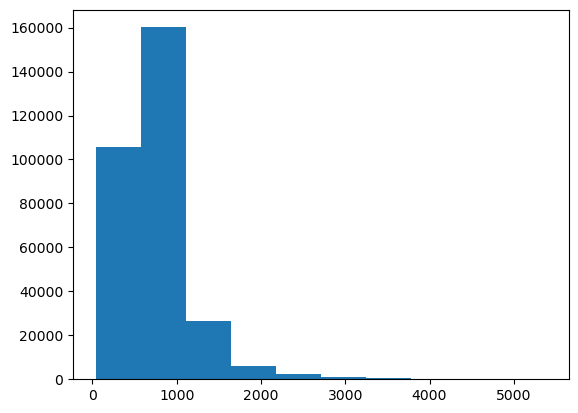

In [109]:
plt.hist(train_X['Customers'])

(array([3.00000e+00, 4.00000e+00, 6.50000e+01, 4.69000e+02, 3.95000e+03,
        3.92790e+04, 1.43355e+05, 9.64660e+04, 1.68240e+04, 1.79500e+03]),
 array([-8.53681674, -7.27879407, -6.0207714 , -4.76274873, -3.50472606,
        -2.24670339, -0.98868072,  0.26934195,  1.52736463,  2.7853873 ,
         4.04340997]),
 <BarContainer object of 10 artists>)

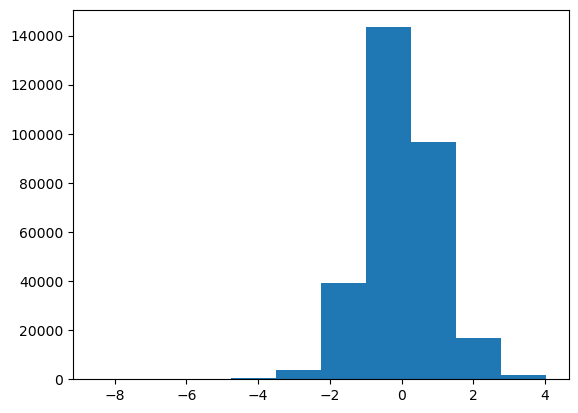

In [110]:
plt.hist(train_X_n['Customers'])

In [111]:
test_X_n= test_X.copy()
validation_X_n= validation_X.copy()
test_X_n[col]=power_transform.transform(test_X_n[col])
validation_X_n[col]=power_transform.transform(validation_X_n[col])
validation_X_n

Customers  Promo  SchoolHoliday       Day     Month  \
Store Date                                                              
672   2014-07-01   1.665719      1              0 -1.944302  0.573280   
      2014-07-02   1.623446      1              0 -1.756429  0.573280   
      2014-07-03   1.433747      1              0 -1.585340  0.573280   
      2014-07-04   1.140460      1              0 -1.425739  0.573280   
      2014-07-05   1.676820      0              0 -1.274732  0.573280   
...                     ...    ...            ...       ...       ...   
892   2014-12-24  -0.773603      0              1  0.938430  1.652489   
      2014-12-27  -0.952373      0              0  1.232482  1.652489   
      2014-12-29   0.613909      0              1  1.423700  1.652489   
      2014-12-30   0.638706      0              1  1.517988  1.652489   
      2014-12-31  -1.536009      0              1  1.611445  1.652489   

                  WeekOfYear  Christmas Holiday  Easter Holiday  Not Holiday  \
Store Date                                                                     
672   2014-07-01    0.473743                  0               0            1   
      2014-07-02    0.473743                  0               0            1   
      2014-07-03    0.473743                  0               0            1   
      2014-07-04    0.473743                  0               0            1   
      2014-07-05    0.473743                  0               0            1   
...                      ...                ...             ...          ...   
892   2014-12-24    1.713968                  0               0            1   
      2014-12-27    1.713968                  0               0            1   
      2014-12-29   -2.031776                  0               0            1   
      2014-12-30   -2.031776                  0               0            1   
      2014-12-31   -2.031776                  0               0            1   

                  Public Holiday  ...  StoreType_a  StoreType_b  StoreType_c  \
Store Date                        ...                                          
672   2014-07-01               0  ...            0            0            1   
      2014-07-02               0  ...            0            0            1   
      2014-07-03               0  ...            0            0            1   
      2014-07-04               0  ...            0            0            1   
      2014-07-05               0  ...            0            0            1   
...                          ...  ...          ...          ...          ...   
892   2014-12-24               0  ...            1            0            0   
      2014-12-27               0  ...            1            0            0   
      2014-12-29               0  ...            1            0            0   
      2014-12-30               0  ...            1            0            0   
      2014-12-31               0  ...            1            0            0   

                  StoreType_d  Assortment_Basic  Assortment_Extended  \
Store Date                                                             
672   2014-07-01            0                 1                    0   
      2014-07-02            0                 1                    0   
      2014-07-03            0                 1                    0   
      2014-07-04            0                 1                    0   
      2014-07-05            0                 1                    0   
...                       ...               ...                  ...   
892   2014-12-24            0                 1                    0   
      2014-12-27            0                 1                    0   
      2014-12-29            0                 1                    0   
      2014-12-30            0                 1                    0   
      2014-12-31            0                 1                    0   

                  Assortment_Extra  CompetitionOp

In [112]:
train_y.value_counts()

Sales
5099     84
5235     83
5359     79
5584     79
5316     78
         ..
21852     1
28564     1
23974     1
18000     1
15636     1
Name: count, Length: 18056, dtype: int64

In [113]:
train_log_y=np.log1p(train_y)
train_log_y.value_counts()

Sales
8.536996     84
8.563313     83
8.586719     79
8.627840     79
8.578665     78
             ..
9.992093      1
10.259937     1
10.084767     1
9.798183      1
9.657395      1
Name: count, Length: 18056, dtype: int64

In [114]:
validation_log_y=np.log1p(validation_y)
validation_log_y.value_counts()

Sales
8.739376    12
8.567126    12
8.672315    12
8.639765    12
8.692490    12
            ..
9.290352     1
9.468001     1
9.698123     1
9.021357     1
9.524056     1
Name: count, Length: 10814, dtype: int64

In [115]:
test_log_y=np.log1p(test_y)
test_log_y.value_counts()

Sales
8.663024    19
8.545003    19
8.746239    17
8.596374    17
8.645762    17
            ..
9.363576     1
9.478151     1
9.373139     1
9.224539     1
9.306287     1
Name: count, Length: 10745, dtype: int64

In [116]:
mutual_info = mutual_info_regression(train_X_n, train_log_y)
mutual_info

array([7.06846217e-01, 9.54652955e-02, 3.06116653e-04, 2.44137864e-02,
       1.04525937e-02, 7.36457852e-02, 6.11513338e-06, 0.00000000e+00,
       3.02311096e-03, 4.81263659e-04, 3.01549649e-03, 1.68469065e-02,
       2.09502966e-02, 2.31375568e-03, 2.68239496e-03, 4.09029065e-04,
       2.84240484e-03, 2.25717334e-03, 2.43002434e-03, 0.00000000e+00,
       1.67467895e-03, 1.24758320e-03, 2.85828969e-01, 8.40661181e-03,
       3.81437193e-03, 8.52382994e-03, 2.67771072e-04, 8.63839812e-03,
       6.02430910e-03, 6.88552751e-03, 1.43043282e-03, 1.56731350e-02,
       1.35895457e-02, 2.41808773e-03])

In [117]:
mutual_info_no_norm = mutual_info_regression(train_X, train_log_y)
mutual_info_no_norm

array([7.07093169e-01, 9.67989560e-02, 8.33857107e-04, 2.44573890e-02,
       9.91363862e-03, 7.30880837e-02, 7.72334098e-04, 0.00000000e+00,
       2.84550078e-03, 9.67207284e-04, 3.92892576e-03, 1.68062632e-02,
       2.30184964e-02, 2.70406308e-03, 2.37811540e-03, 0.00000000e+00,
       2.77530937e-03, 2.21445993e-03, 2.44621231e-03, 0.00000000e+00,
       1.02467533e-03, 1.29327944e-03, 2.18518628e-01, 9.34784671e-03,
       5.52957817e-03, 8.52537047e-03, 7.76096099e-05, 8.22646559e-03,
       6.01893865e-03, 6.86790203e-03, 8.63912792e-04, 1.67014657e-02,
       1.46715183e-02, 2.44212949e-03])

In [118]:
mutual_info = pd.DataFrame(mutual_info)
mutual_info_no_norm = pd.DataFrame(mutual_info_no_norm)

In [119]:
mutual_info.to_csv('data/mutual_info_norm.csv', index=False)
mutual_info_no_norm.to_csv('data/mutual_info_no_norm.csv', index=False)

In [120]:
mutual_info = mutual_info.sort_values(by=[0], ascending=False)
mutual_info 

,0
0,0.706846
22,0.285829
1,0.095465
5,0.073646
3,0.024414
12,0.020950
11,0.016847
31,0.015673
32,0.013590
4,0.010453


In [121]:
mutual_info_no_norm = mutual_info_no_norm.sort_values(by=[0], ascending=False)
mutual_info_no_norm 

,0
0,0.707093
22,0.218519
1,0.096799
5,0.073088
3,0.024457
12,0.023018
11,0.016806
31,0.016701
32,0.014672
4,0.009914


In [122]:
cols_for_models = mutual_info.iloc[:25,]
cols_for_models_no_norm = mutual_info_no_norm.iloc[:25,]

In [123]:
cols_for_models

,0
0,0.706846
22,0.285829
1,0.095465
5,0.073646
3,0.024414
12,0.020950
11,0.016847
31,0.015673
32,0.013590
4,0.010453


In [124]:
cols_for_models=cols_for_models.index
cols_for_models
cols_for_models_no_norm=cols_for_models_no_norm.index
cols_for_models_no_norm

Index([ 0, 22,  1,  5,  3, 12, 11, 31, 32,  4, 23, 25, 27, 29, 28, 24, 10,  8,
       16, 13, 18, 33, 14, 17, 21],
      dtype='int64')

In [125]:
cols_for_models=cols_for_models.sort_values()
cols_for_models_no_norm=cols_for_models_no_norm.sort_values()
cols_for_models=list(cols_for_models)
cols_for_models_no_norm=list(cols_for_models_no_norm)
cols_for_models

[0,
 1,
 3,
 4,
 5,
 8,
 10,
 11,
 12,
 13,
 14,
 16,
 17,
 18,
 20,
 22,
 23,
 24,
 25,
 27,
 28,
 29,
 31,
 32,
 33]

In [126]:
train_X_n_reduced=train_X_n.iloc[:,cols_for_models]
validation_X_n_reduced=validation_X_n.iloc[:,cols_for_models]
test_X_n_reduced=test_X_n.iloc[:,cols_for_models]

train_X_reduced=train_X.iloc[:,cols_for_models_no_norm]
validation_X_reduced=validation_X.iloc[:,cols_for_models_no_norm]
test_X_reduced=test_X.iloc[:,cols_for_models_no_norm]

In [127]:
def RMSPE_(y_true_log, y_predicted_log):
    y_true=np.expm1(y_true_log)
    y_pred=np.expm1(y_predicted_log)
    rmspe= np.sqrt(np.mean(np.power((y_true - y_pred) / (y_true),2)))
    return rmspe

RMSPE = make_scorer(RMSPE_,greater_is_better=False)

In [128]:
RMSPE_(np.log1p(2),np.log1p(3))

0.49999999999999967

# Modeli

### Linearna regresija

In [276]:
model_lr=LinearRegression()

model_lr.fit(train_X_n_reduced, train_log_y)

val_pred=model_lr.predict(validation_X_n_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=model_lr.predict(test_X_n_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.16750114085359444
Test RMSPE:  0.14888031382441624


In [130]:
ridge_model = Ridge()

ridge_model.fit(train_X_n_reduced, train_log_y)

val_pred=ridge_model.predict(validation_X_n_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=ridge_model.predict(test_X_n_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.1674957748686782
Test RMSPE:  0.14887540972898242


In [131]:
lasso_model = Lasso()

lasso_model.fit(train_X_n_reduced, train_log_y)

val_pred=lasso_model.predict(validation_X_n_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=lasso_model.predict(test_X_n_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.5190950242680888
Test RMSPE:  0.5349272487290293


In [132]:
param_grid = {'alpha': np.logspace(start=-8,stop= 8, num=20)}

best_model_ridge = None
rmspe_best=float('inf')

for alpha in param_grid['alpha']:
    model = Ridge(alpha=alpha)
    model.fit(train_X_n_reduced, train_log_y)
    
    val_pred=model.predict(validation_X_n_reduced)
    rmspe=RMSPE_(validation_log_y, val_pred)
    
    if rmspe < rmspe_best:
        rmspe_best = rmspe
        best_model_ridge = model

print('Best alpha: ', best_model_ridge.alpha)    

val_pred=best_model_ridge.predict(validation_X_n_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=best_model_ridge.predict(test_X_n_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Best alpha:  127.42749857031322
Validation RMSPE:  0.16704589269103193
Test RMSPE:  0.14844345888066007


In [133]:
param_grid = {'alpha': np.logspace(start=-8,stop= 8, num=20)}

best_model_lasso = None
rmspe_best=float('inf')
alpha_list=[]

for alpha in param_grid['alpha']:
    model = Lasso(alpha=alpha)
    model.fit(train_X_n_reduced, train_log_y)
    
    val_pred=model.predict(validation_X_n_reduced)
    rmspe=RMSPE_(validation_log_y, val_pred)
    
    if rmspe < rmspe_best:
        alpha_list.append(alpha)
        rmspe_best = rmspe
        best_model_lasso = model

print('Best alpha: ', best_model_lasso.alpha)

val_pred=best_model_lasso.predict(validation_X_n_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=best_model_lasso.predict(test_X_n_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Best alpha:  0.0001623776739188721
Validation RMSPE:  0.167083591642571
Test RMSPE:  0.1485069547803159


### Stablo odlucivanja


In [134]:
dt_model = DecisionTreeRegressor()

dt_model.fit(train_X_reduced, train_log_y)

val_pred=dt_model.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=dt_model.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.22615360978415786
Test RMSPE:  0.22164523300655245


In [165]:
max_depths=[15,20,25,30]
min_samples_leafs=[50,60]
min_samples_split_values = [5,10, 20]
best_model_tree = None
rmspe_best=float('inf')

for md in max_depths:
    for msl in min_samples_leafs:
        for mssl in min_samples_split_values:
            model= DecisionTreeRegressor(max_depth=md, min_samples_leaf=msl,min_samples_split=mssl)
            model.fit(train_X_reduced, train_log_y)
    
            val_pred=model.predict(validation_X_reduced)
            rmspe=RMSPE_(validation_log_y, val_pred)

            if rmspe < rmspe_best:
                rmspe_best = rmspe
                best_model_tree = model


val_pred=best_model_tree.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=best_model_tree.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

print("Best Hyperparameters:")
print("Max Depth:", best_model_tree.max_depth)
print("Min Samples Leaf:", best_model_tree.min_samples_leaf)
print("Min Samples Split:", best_model_tree.min_samples_split)

Validation RMSPE:  0.19944208739673053
Test RMSPE:  0.18587155247249612
Best Hyperparameters:
Max Depth: 15
Min Samples Leaf: 60
Min Samples Split: 20


In [162]:
dt_model = DecisionTreeRegressor(max_depth=15,min_samples_leaf=60)
dt_model.fit(train_X_reduced, train_log_y)

val_pred=dt_model.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=dt_model.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.199648905466874
Test RMSPE:  0.18590300044436978


## Stacking

In [215]:
base_regressors = [
    ('tree', DecisionTreeRegressor()),
    ('lr', best_model_ridge)
]

meta_regressor =best_model_ridge 

model_stacking = StackingRegressor(
    estimators=base_regressors,
    final_estimator=meta_regressor
)

In [216]:
model_stacking.fit(train_X_reduced, train_log_y)

val_pred=model_stacking.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=model_stacking.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.23014939656067598
Test RMSPE:  0.1899051188897701


In [191]:
base_regressors2 = [
    ('tree', DecisionTreeRegressor()),
    ('lr', LinearRegression())
]

meta_regressor2 = best_model_tree

model_stacking2 = StackingRegressor(
    estimators=base_regressors2,
    final_estimator=meta_regressor2
)

In [193]:
model_stacking2.fit(train_X_reduced, train_log_y)

val_pred=model_stacking2.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=model_stacking2.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.19568358443195696
Test RMSPE:  0.1730488619857425


## Bagging

In [250]:
model_tree = best_model_tree

model_bagging_tree = BaggingRegressor(estimator=model_tree, n_estimators=20)
model_bagging_tree.fit(train_X_reduced, train_log_y)

val_pred=model_bagging_tree.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=model_bagging_tree.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.18338358709624283
Test RMSPE:  0.17172832725636794


In [253]:
model_lr = best_model_ridge

model_bagging_lr = BaggingRegressor(estimator=model_lr, n_estimators=5)
model_bagging_lr.fit(train_X_n_reduced, train_log_y)

val_pred=model_bagging_lr.predict(validation_X_n_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=model_bagging_lr.predict(test_X_n_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.16701151923343455
Test RMSPE:  0.14844357141018033


In [227]:
best_rmspe = float('inf')
best_params = {}
n_estimators_values = [20, 25, 30, 35]
max_samples_values = [0.75, 1.0]
max_features_values = [0.5, 0.75, 1.0]
best_model_bagging=None
for n_estimators in n_estimators_values:
    for max_samples in max_samples_values:
        for max_features in max_features_values:
            model = BaggingRegressor(estimator=best_model_tree, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features)
            model.fit(train_X_reduced, train_log_y)
            y_pred = model.predict(validation_X_reduced)
            
            rmspe = RMSPE_(validation_log_y, y_pred)
            
            if rmspe < best_rmspe:
                best_rmspe = rmspe
                best_model_bagging=model
                best_params = {'n_estimators': n_estimators, 'max_samples': max_samples, 'max_features': max_features}

print("Best hyperparameters:", best_params)
print("Best RMSPE:", best_rmspe)

Best hyperparameters: {'n_estimators': 30, 'max_samples': 0.75, 'max_features': 1.0}
Best RMSPE: 0.1809480126644504


In [234]:
bagging = BaggingRegressor(estimator=best_model_tree, n_estimators=30, max_samples=0.75, max_features=1.0)
bagging.fit(train_X_reduced, train_log_y)

val_pred=bagging.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=bagging.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.18154955906068537
Test RMSPE:  0.16901485685424725


## RandomForest

In [277]:
forest = RandomForestRegressor(n_jobs=-1, n_estimators=40, random_state=42, max_depth=25,min_samples_split=40, min_samples_leaf=40 )
forest.fit(train_X_reduced, train_log_y)

val_pred=forest.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=forest.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.18610454418983977
Test RMSPE:  0.17257894890696063


In [259]:
min_samples_leaf= list(range(1,100,3))
n_estimators=[50, 100]
best_rmspe = float('inf')
best_params = {}
best_model_forest=None

#for n in n_estimators:
for leaf in min_samples_leaf:
        model =RandomForestRegressor(n_jobs= -1,n_estimators=50, random_state=42, max_depth=20,min_samples_split=40, min_samples_leaf=leaf )

        model.fit(train_X_reduced, train_log_y)
        y_pred = model.predict(validation_X_reduced)
            
        rmspe = RMSPE_(validation_log_y, y_pred)
            
        if rmspe < best_rmspe:
            best_rmspe = rmspe
            best_model_forest= model
            best_params = {'min_samples_leaf': min_samples_leaf}

print("Best hyperparameters:", best_params)
print("Best RMSPE:", best_rmspe)

val_pred=best_model_forest.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=best_model_forest.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))


Best hyperparameters: {'min_samples_leaf': [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97]}
Best RMSPE: 0.18118257095699425
Validation RMSPE:  0.18118257095699428
Test RMSPE:  0.16859681465857285


In [260]:
best_model_forest.min_samples_leaf

97

In [262]:
model_forest =RandomForestRegressor(n_jobs= -1,n_estimators=100, random_state=42, max_depth=20,min_samples_split=40, min_samples_leaf=97 )
model_forest.fit(train_X_reduced, train_log_y)

val_pred=model_forest.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=model_forest.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.18106236921224453
Test RMSPE:  0.1682359171764851


## Boosting

In [232]:
model_ada = ada = AdaBoostRegressor(n_estimators=30)

model_ada.fit(train_X_reduced, train_log_y)

val_pred=model_ada.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=model_ada.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.23859707509584455
Test RMSPE:  0.20108837170831068


In [233]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1.0]}
best_rmspe = float('inf')
best_model_ada=None

for lr in param_grid['learning_rate']:
    model = AdaBoostRegressor(n_estimators=300, learning_rate=lr)

    model.fit(train_X_reduced, train_log_y)
    y_pred = model.predict(validation_X_reduced)
            
    rmspe = RMSPE_(validation_log_y, y_pred)
            
    if rmspe < best_rmspe:
        best_rmspe = rmspe
        best_model_ada= model

print("Best learning rate:", best_model_ada.learning_rate_)

val_pred=best_model_ada.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=best_model_ada.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Best hyperparameters: {'n_estimators': 35, 'max_samples': 1.0, 'max_features': 1.0}
Best RMSPE: 0.21430582183651856
Validation RMSPE:  0.21430582183651856
Test RMSPE:  0.21269767176933962


In [243]:
print(best_model_ada.learning_rate)

0.01


In [241]:
model_gbr = GradientBoostingRegressor(n_estimators=30,learning_rate=0.2)

model_gbr.fit(train_X_reduced, train_log_y)

val_pred=model_gbr.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=model_gbr.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.16285926839039097
Test RMSPE:  0.15937543347726957


In [239]:
best_rmspe = float('inf')
best_params = {}

n_estimators_values = [50, 100, 150]
learning_rate_values = [0.01, 0.1, 1.0]
for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
            model_gbr = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
            
            
            model_gbr.fit(train_X_reduced, train_log_y)
            y_pred = model_gbr.predict(validation_X_reduced)
            
            rmspe = RMSPE_(validation_log_y, y_pred)
            if rmspe < best_rmspe:
                best_rmspe = rmspe
                best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

print("Best hyperparameters:", best_params)
print("Best RMSPE:", best_rmspe)

Best hyperparameters: {'n_estimators': 150, 'learning_rate': 0.1}
Best RMSPE: 0.15530753338138467


In [246]:
best_model_gbr = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1)
best_model_gbr.fit(train_X_reduced, train_log_y)
val_pred=best_model_gbr.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))
test_pred=best_model_gbr.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.15530230735166708
Test RMSPE:  0.15245594297846718


In [240]:
model_xg = model = xgb.XGBRegressor()

model_xg.fit(train_X_reduced, train_log_y)

val_pred=model_xg.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))

test_pred=model_xg.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.18234559446879883
Test RMSPE:  0.18350218086528833


In [274]:
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.01, 0.1, 0.2]

best_rmspe = float('inf')
best_params = {}

for n_estimators in n_estimators_values:
        for learning_rate in learning_rate_values:
            model = xgb.XGBRegressor(n_estimators=n_estimators,learning_rate=learning_rate)
            model.fit(train_X_reduced, train_log_y)
            y_pred = model.predict(validation_X_reduced)
            rmspe = RMSPE_(validation_log_y, y_pred)
            if rmspe < best_rmspe:
                best_rmspe = rmspe
                best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

print("Best hyperparameters:", best_params)
print("Best RMSPE:", best_rmspe)

Best hyperparameters: {'n_estimators': 50, 'learning_rate': 0.1}
Best RMSPE: 0.16125714029413374


In [247]:
best_model_xg = xgb.XGBRegressor(n_estimators=50,learning_rate=0.1)
best_model_xg.fit(train_X_reduced, train_log_y)
val_pred=best_model_xg.predict(validation_X_reduced)
print('Validation RMSPE: ', RMSPE_(validation_log_y, val_pred))
test_pred=best_model_xg.predict(test_X_reduced)
print('Test RMSPE: ', RMSPE_(test_log_y, test_pred))

Validation RMSPE:  0.16125714029413374
Test RMSPE:  0.1665657421876073


<Axes: ylabel='att'>

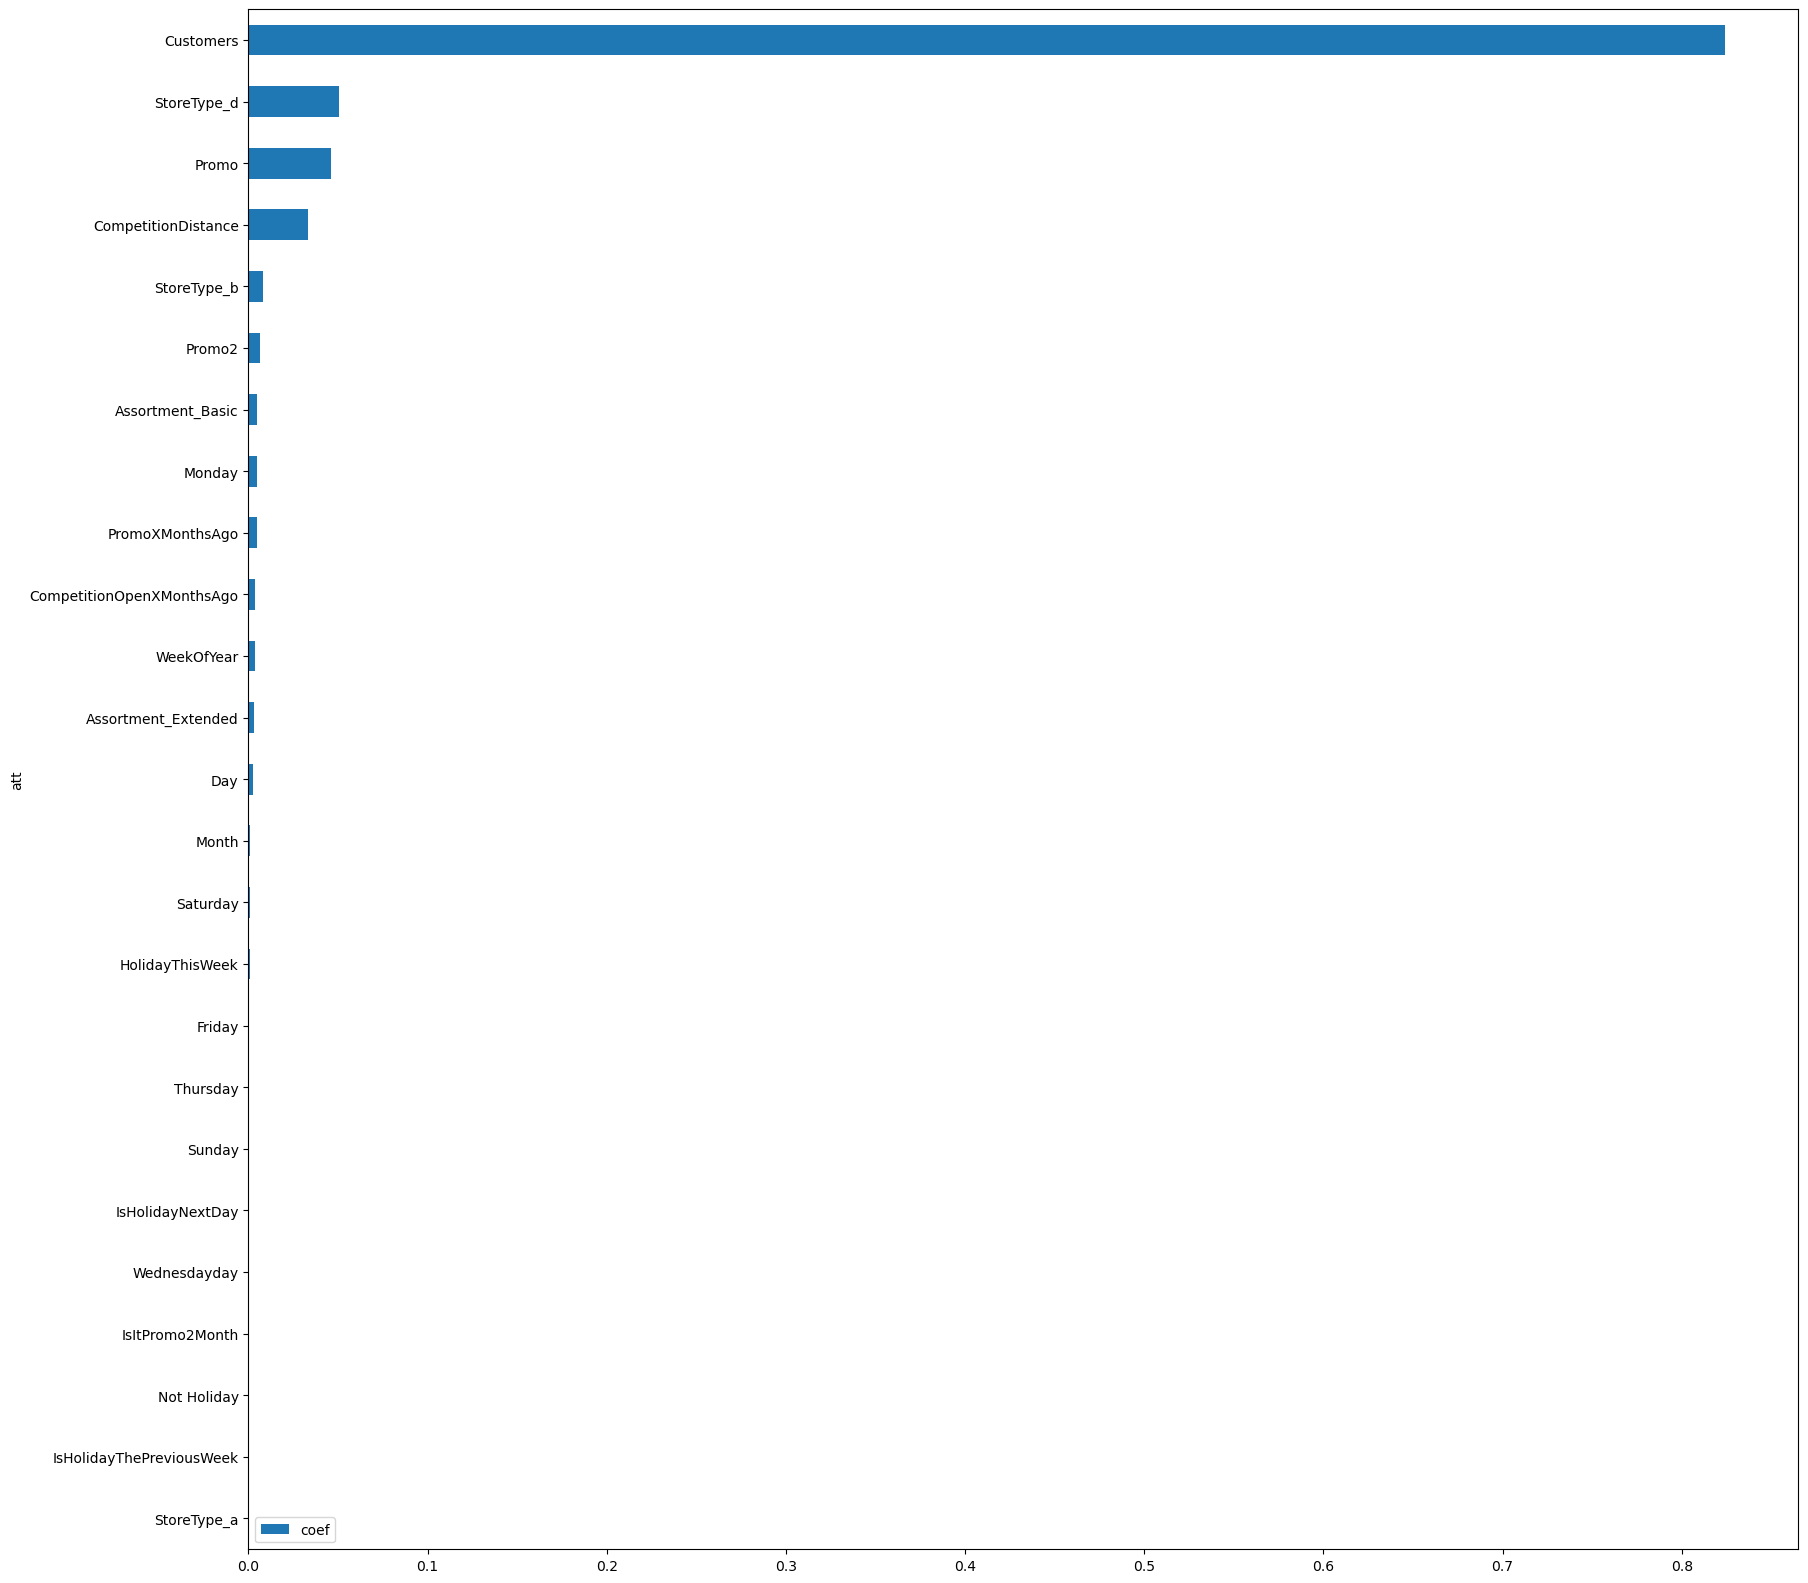

In [267]:
import seaborn as sns
%matplotlib inline

coefs = pd.DataFrame({'att':train_X_reduced.columns, 'coef':best_model_gbr.feature_importances_}).sort_values(by='coef',ascending=True).replace(0,np.nan).dropna()
coefs.plot.barh(x='att',y='coef',figsize=(20, 20))